## Importing relevant libraries

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.spatial as spat
from scipy.stats import unitary_group
from scipy.stats import moment
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit
from scipy.linalg import norm
import matplotlib.pyplot as plt
import math
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from qiskit import *
from qiskit import execute
from qiskit import transpiler
from qiskit.circuit.add_control import add_control
from qiskit.extensions import UnitaryGate
from qiskit.circuit.reset import Reset
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit.library.standard_gates import IGate, UGate, U3Gate
from qiskit.dagcircuit import DAGOpNode, DAGInNode
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.synthesis import OneQubitEulerDecomposer
from qiskit.transpiler.passes.optimization import Optimize1qGates
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler.exceptions import TranspilerError
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, complete_meas_cal
from math import fsum
from qiskit.visualization import plot_gate_map, plot_circuit_layout, plot_error_map
from scipy.optimize import minimize
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.providers.models import BackendConfiguration
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.transpiler.passes import BasisTranslator
from qiskit import QuantumCircuit, IBMQ, transpile
from qiskit.circuit import Delay
from qiskit.circuit.library import XGate, YGate, ZGate, RXGate, RYGate, RZGate
from qiskit.transpiler.passes import ALAPSchedule
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.providers.fake_provider import FakeMontreal
from qiskit.providers.fake_provider import FakeJakarta
from qiskit.providers.fake_provider import FakeMumbai
from qiskit.providers.fake_provider import FakeHanoi
from qiskit.providers.fake_provider import FakeLagos
from qiskit.providers.fake_provider import FakeMelbourne
from qiskit.providers.fake_provider import FakeGuadalupe
from qiskit.providers.fake_provider import FakeNairobi
from qiskit.providers.fake_provider import FakeToronto
from qiskit.providers.fake_provider import FakeWashington
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.aer import AerSimulator

# Import Paddle libraries
import paddle
from paddle_quantum.ansatz import Circuit
from paddle_quantum.linalg import dagger

C:\Users\abc\AppData\Local\Temp\ipykernel_7084\2262379397.py:28: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, complete_meas_cal
C:\Users\abc\anaconda3\lib\site-packages\openfermion\hamiltonians\hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
C:\Users\abc\anaconda3\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.

## Constructing the FPE operator and implementing helper functions

In [2]:
## Classical implementation
"""
Purpose: 
    Find the analytical solution given the input parameters
Input: 
    x: array representing the x coordinates over which the solution is to be found
    a, Γ: parameters for the Ornstein-Uhlenbeck equation
Output:
    y: array of the value of the analytical solution over x
"""

def OrnsteinUhlenbeck(x, a = 1, gamma = 1):
    y = np.sqrt(a/(2*np.pi*gamma)) * np.exp((-a * x ** 2)/(2*gamma))
    
    return y

"""
Purpose:
    Calculate the weighted Hermite polynomials using recursive relations up to H_n
Input:
    n: the highest number of Hermite polynomials to be evaluated at
    x: the value of x at which the weighted Hermite polynomials are to be evaluated
Output:
    Hermite: the value of the weighted Hermite polynomials
Example: HermiteSeries(2, 4) -> [H_0(4), H_1(4), H_2(4)]
"""

def HermiteSeries(n, x):
    Hermite = np.zeros((1, n+1))
    Hermite[0][0] = 1.0 * np.exp(-x**2/2)
    Hermite[0][1] = 2.0 * x *np.exp(-x**2/2)
    
    for ni in range(1, n):
        Hermite[0][ni+1] = 2*x*Hermite[0][ni] - 2*ni*Hermite[0][ni-1]
    
    return Hermite

"""
Purpose:
    Reconstruct the functions represented by the coefficients of weighted Hermite polynomials in spatial coordinates
Input:
    x: array containing the x values over which the function is to be evaluated
    coefficients: the coefficients corresponding to the Hermite polynomials (should be zero-mode of the operator)
    nmax: the highest order of weighted Hermite polynomials used
    s: the scaling factor
Output:
    y: the reconstruction
"""

def project(x, coefficients, nmax, s):
    
    y = np.zeros(x.shape)
    
    for i in (range(len(x))):
        x0 = s*x[i]
        hermite_values = HermiteSeries(nmax, x0)
        y[i] += np.dot(hermite_values, coefficients)
        
    return (x, y)

"""
Purpose:
    Normalize the PDF so that the area under the curve is 1
Input:
    x, y: arrays representing the unnormalized
Output:
    (x, y): normalized PDF
"""

def normalize(x, y):
    dx = x[1] - x[0]
    sum = 0
    
    for i in range(len(x)):
        sum = sum + (y[i] * dx)
    
    y = y/sum
    
    return (x, y)

"""
Purpose:
    Calculate the RMS
Input:
    y_op, y: the y values generated by the operator and the analytical solution
Output:
    RMS
"""

def rms_diff(y_op, y):
    return np.sqrt(np.sum((y_op-y)**2)/len(y))

"""
Purpose:
    Find s given a and Γ such that the projection in Hermite space is just H_0
Input:
    a, Γ: parameters for Ornstein-Uhlenbeck
Output:
    s
"""

def special_s(a, gamma):
    return np.sqrt(a/gamma)

def euler_representation(z):
    A = abs(z)
    phase = math.atan(z.imag/z.real)
    
    return A, phase

def generate_positive_semidefinite_matrix(eigenvalues):
    ## Function to transform the FPE operator to the Hermite basis and return a finite truncated matrix for the ...
    ## ... FPE operator
    
    n = len(eigenvalues)
    s = np.diag(eigenvalues)
    q, _ = la.qr(np.random.rand(n, n))
    semidef = np.dot(np.transpose(q), s)
    semidef = np.dot(semidef, q)
    
    return semidef

def normalize_probability(y, dx):
    ## Function to return a normalized PDF 
    
    total = np.sum(y) * dx
    y = y / total
    
    return y

def perturbed_ornstein_uhlenbeck(x0, a = 1, gamma = 1, c = 0, shift = 0):
    ## Function to compute the exact solution to the perturbed Ornstein-Uhlenbeck equation
    
    assert len(x0) > 1, "Error: x0 should be a vector"

    x = x0 - shift
    y = np.exp(-a*x**2 /(2*gamma) - c*x**4 /(4*gamma))
    dx = x[2] - x[1]
    
    y = normalize_probability(y, dx)
    
    return y

def special_L(a, gamma):
    ## Function to compute the characteristic length scale
    
    return np.sqrt(a/gamma)

def delta(N, n):
    ## Function to implement the Kronecker delta function
    
    if N == n:
        return 1
    else:
        return 0

def f(N,n):
    return 0.5*( np.sqrt(n*(n-1))*delta(N,n-2) + delta(N,n) - np.sqrt((n+1)*(n+2))*delta(N,n+2))

def g(N,n, L):
    return 0.5*L**2*( np.sqrt(n*(n-1))*delta(N,n-2) - (2*n+1)*delta(N,n) + np.sqrt((n+1)*(n+2))*delta(N,n+2))

def t(N, n, L):
    val1 = np.sqrt(n*(n-1)*(n-2)*(n-3))*delta(N, n-4)
    val2 = (2*n+2)*np.sqrt(n*(n-1))*delta(N, n-2)
    val3 = (6*n+3)*delta(N, n)
    val4 = -2*n*np.sqrt((n+1)*(n+2))*delta(N, n+2)
    val5 = -1*np.sqrt((n+1)*(n+2)*(n+3)*(n+4))*delta(N, n+4)

    return 1/(4*L**2)*( val1 + val2 + val3 + val4 + val5 )

def element_perturbed(N, n, L, a, c, gamma):
    ## Function to compute the matrix elements of the finite truncated matrix for the FPE operator (in the Hermite basis)
    
    return -(a*f(N,n) + c*t(N, n, L) + gamma*g(N, n, L))

def create_operator_perturbed(nmax, L, a, c, gamma):
    ## Function to generate the FPE operator matrix in the Hermite basis
    op = np.zeros((nmax+1, nmax+1))
    
    for N in range(nmax+1):
        row = N
        for n in range(nmax+1):
            col = n
            op[row, col] = element_perturbed(N, n, L, a, c, gamma)
    
    """
    if np.any(np.nan, op):
        print("There's an nan in the operator")
    elif np.any(np.inf, op):
        print("There is an inf in the operator")
    """

    return op

def state_n(nmax, x0, L):
    ## Function to compute the Hermite polynomials upto the order specified by nmax
    
    assert L > 0, "Error (state_n): input L must be greater than or equal to 0"

    states = np.zeros(nmax + 1)
    x = x0*L

    states[0] = np.sqrt(L*np.sqrt(1/np.pi))* 1.0 * np.exp(-x**2/2)

    if nmax > 0:
        states[1] = np.sqrt(L*np.sqrt(1/np.pi))* (1/np.sqrt(2)) * 2.0 * x * np.exp(-(x**2)/2)
    
    for ni in range(2, nmax + 1):
        states[ni] = ((np.sqrt(2)*x) / np.sqrt(ni))*states[ni-1] - (ni-1)/np.sqrt((ni)*(ni-1))*states[ni-2]

    return states

def integrate_eigenvector(x0, y, nmax, L):
    ## Function to compute the coefficients corresponding to the calculated Hermite polynomials by numerical integration
    ## Note: here, we use the left-hand integration method
    
    dx = x0[2] - x0[1]
    eigenvector = np.zeros(nmax + 1)

    for i in range(len(x)):

        states = state_n(nmax, x0[i], L)
        states = states * y[i] * dx

        eigenvector = eigenvector + states
        
    return {"eigenvector" : eigenvector, "dx" : dx, "nmax" : nmax, "x0" : x0, "L" : L}

def make_operator_even(op):
    op_new = np.zeros((op.shape[0]//2, op.shape[1]//2))
    
    for row in range(op_new.shape[0]):
        for col in range(op_new.shape[1]):
            op_new[row, col] = op[row*2, col * 2]
    
    return op_new

def reconstruct_eigenvector(cache, normalize = True, only_even = False):
    ## Function to reconstruct the PDF using the cache obtained previously
    
    eigenvector = cache["eigenvector"]
    nmax = cache["nmax"]
    x0 = cache["x0"]
    dx = cache["dx"]
    L = cache["L"]
    
    if not only_even:
        eigenvector = cache["eigenvector"]
    else:
        eigenvector_old = cache["eigenvector"]
        eigenvector = np.zeros(nmax + 1)
        
        for i in range(len(eigenvector_old)):
            eigenvector[2*i] = eigenvector_old[i]

    y = np.zeros(len(x0))

    for i in range(len(x0)):
        states = state_n(nmax, x0[i], L)
        y[i] += (np.dot(states, eigenvector))
    if normalize:   
        y = normalize_probability(y, dx)
        
    return (x0, y)

def find_zeromode(op_nonhermitian, nmax, x0, dx, L, which = "single", only_even = False):
    ## Function to compute the zeromode, its position, and the eigenvalue corresponding to the zeromode
    
    assert which == "nonhermitian" or which == "single", "Error: currently only supports which = {\"nonhermitian\", \"single\"}"
    
    if only_even:
        op_processed = make_operator_even(op_nonhermitian)
    else:
        op_processed = op_nonhermitian
        
    if which == "nonhermitian":
        op = op_processed
    elif which == "single":
        op = np.dot(np.transpose(op_processed), op_processed)

    eigenvalues, eigenvectors = la.eig(op)

    index = np.argmin(np.real(eigenvalues)**2)

    min_eigenval = eigenvalues[index]
    
    zeromode = eigenvectors[:, index]

    return {"operator" : op, "which" : which, \
            "eigenvector" : np.real(zeromode), "index" : index, "eigenvalue" : np.real(min_eigenval), \
            "nmax" : nmax, "x0" : x0, "dx" : dx, "L" : L, "spectrum" : eigenvalues, "P" : eigenvectors}

def rms_diff(y0, y, sigdigits = 0):
    ## Function to compute the RMS difference between the analytically computed PDF and the one ...
    ## ... obtained using the FPE operator
    
    assert len(y0) == len(y), "Error: the length of y0 and y should be the same"
    diff = np.sum((y0-y)**2)/len(y0)
    
    return np.sqrt(diff)

def analyze_collapse(initial_state, P, index):
    num_basis = P.shape[1]
    coefficients = np.zeros((num_basis, ))

    for i in range(num_basis):
        basis = P[:, i]
        basis = normalize_eigenvector(basis)

        coefficients[i] = np.dot(basis, initial_state)

    normalized_coefficients = normalize_eigenvector(coefficients)

    reconstruction = np.zeros((P.shape[0], ))

    for i in range(num_basis):
        basis = P[:, i]
        basis = normalize_eigenvector(basis)

        added_vector = coefficients[i] * basis
        reconstruction = reconstruction + added_vector

    probability = normalized_coefficients ** 2
    
    probability_zeromode = probability[index]
    assert np.sum(probability) - 1 < 0.00001, "Error: unity normalization of probability is not observed"

    print("The initial_state is: ")
    print(initial_state)
    print()

    print("The coefficient expansion is: ")
    print(coefficients)
    print()

    print("The normalized coefficient expansion is: ")
    print(normalized_coefficients)
    print()

    print("The reconstructed vector is: ")
    print(reconstruction)
    print()

    print("The probability of collapsing into each eigenvector is: ")
    print(probability)
    print()

    print("The probability of collapsing into the zeromode is: ")
    print(probability_zeromode)
    print()
    
    return probability_zeromode, probability

## Defining a cutoff and generating plots accordingly

In [3]:
def cutoff_graph(x, y, y_cutoff):
    # Function to obtain the bounded x and y values (PDF on the log scale)
    
    x_values = [x_val for x_val, y_val in zip(x, y) if y_val >= y_cutoff]
    y_values = [y_val for y_val in y if y_val >= y_cutoff]
    
    return x_values, y_values

## Defining model parameters and computing the exact analytical solution

In [4]:
dx = 0.01
a = 10
gamma = 2
c = 3
L = 2
shift = 0

# Defining x array and computing the exact analytical solution
x = np.linspace(-10, 10, int((20)/dx))
y = perturbed_ornstein_uhlenbeck(x, a = a, gamma = gamma, c = c, shift = shift)

# Initialize
rms_difference = []

## Exact diagonalization results for different Hermite polynomial basis sizes

## For n = 4

### Compute the steady-state PDF via exact diagonalization

In [5]:
# Define max. size of Hermite polynomial basis size
nmax = 7

## Finding the zeromode through direct integration
cache_projection = integrate_eigenvector(x, y, nmax, L)
x_projection, y_projection = reconstruct_eigenvector(cache_projection)

## Finding the zeromode through diagonalization
op_nonhermitian = create_operator_perturbed(nmax, L, a, c, gamma)
only_even = True

cache_diagonalization = find_zeromode(op_nonhermitian, nmax, x, dx, L, which = "single", only_even = only_even)
x_diagonalization, y_diagonalization = reconstruct_eigenvector(cache_diagonalization, only_even = only_even)

### Compare (exact analytical solution vs. exact diagonalization)

The RMS deviation is:
0.0015462546039227757



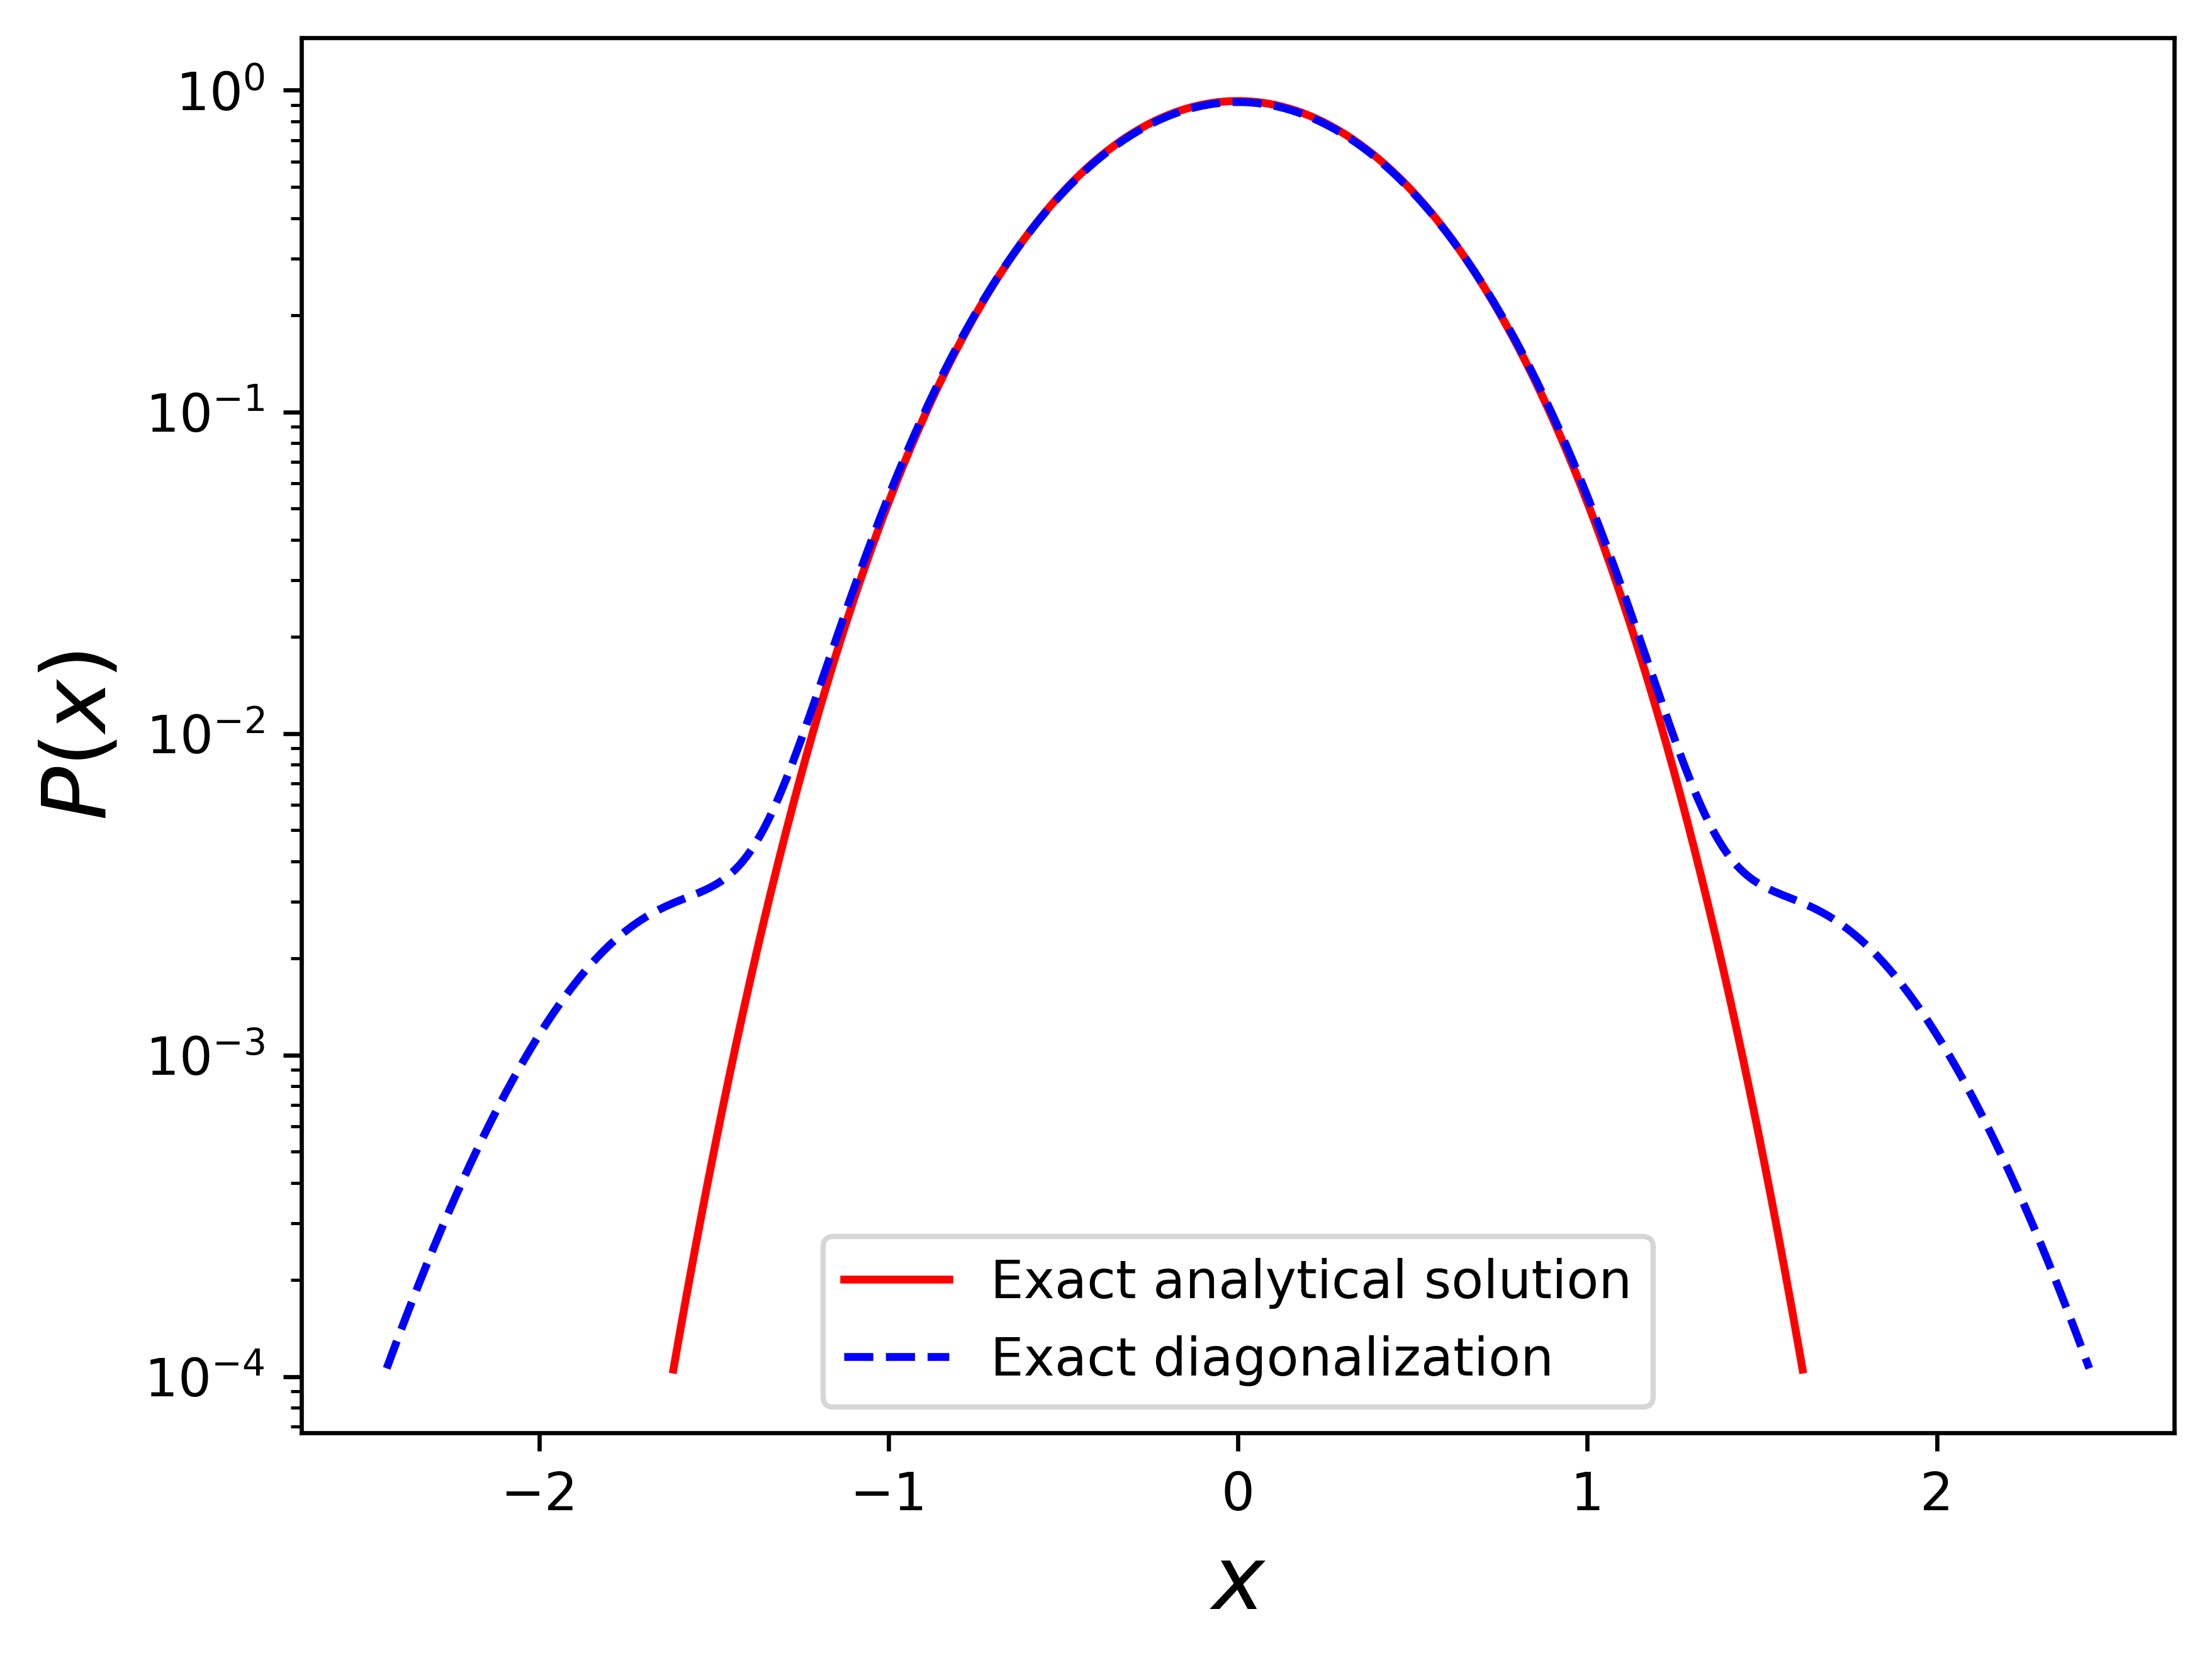

In [6]:
# Compute the RMS deviation and append it to rms_difference for the RMS deviation plot
rms_deviation = rms_diff(y_diagonalization, y)
rms_difference.append(rms_deviation)

# Print the RMS deviation
print('The RMS deviation is:')
print(rms_deviation)
print()

# Compare the steady-state PDFs
y_cutoff = 1 * 1e-4

x_classical, y_classical = cutoff_graph(x, y, y_cutoff) # exact analytical solution
x_diagonal, y_diagonal = cutoff_graph(x, y_diagonalization, y_cutoff) # exact diagonalization

fig, ax = plt.subplots(dpi = 600)

# Plot the first set of data on a log base 2 scale
ax.plot(x_classical, y_classical, color = 'r', label = 'Exact analytical solution')

# Plot the second set of data on a log base 2 scale
ax.plot(x_diagonal, y_diagonal, '--b', label = 'Exact diagonalization')

# Set y-axis to a log scale
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('$x$', fontsize = 17)
ax.set_ylabel('$P(x)$', fontsize = 17)

# Show a legend
ax.legend()

### For n = 6

### Compute the steady-state PDF via exact diagonalization

In [7]:
# Define max. size of Hermite polynomial basis size
nmax = 11

## Finding the zeromode through direct integration
cache_projection = integrate_eigenvector(x, y, nmax, L)
x_projection, y_projection = reconstruct_eigenvector(cache_projection)

## Finding the zeromode through diagonalization
op_nonhermitian = create_operator_perturbed(nmax, L, a, c, gamma)
only_even = True

cache_diagonalization = find_zeromode(op_nonhermitian, nmax, x, dx, L, which = "single", only_even = only_even)
x_diagonalization, y_diagonalization = reconstruct_eigenvector(cache_diagonalization, only_even = only_even)

### Compare (exact analytical solution vs. exact diagonalization)

The RMS deviation is:
0.00019735771423957718



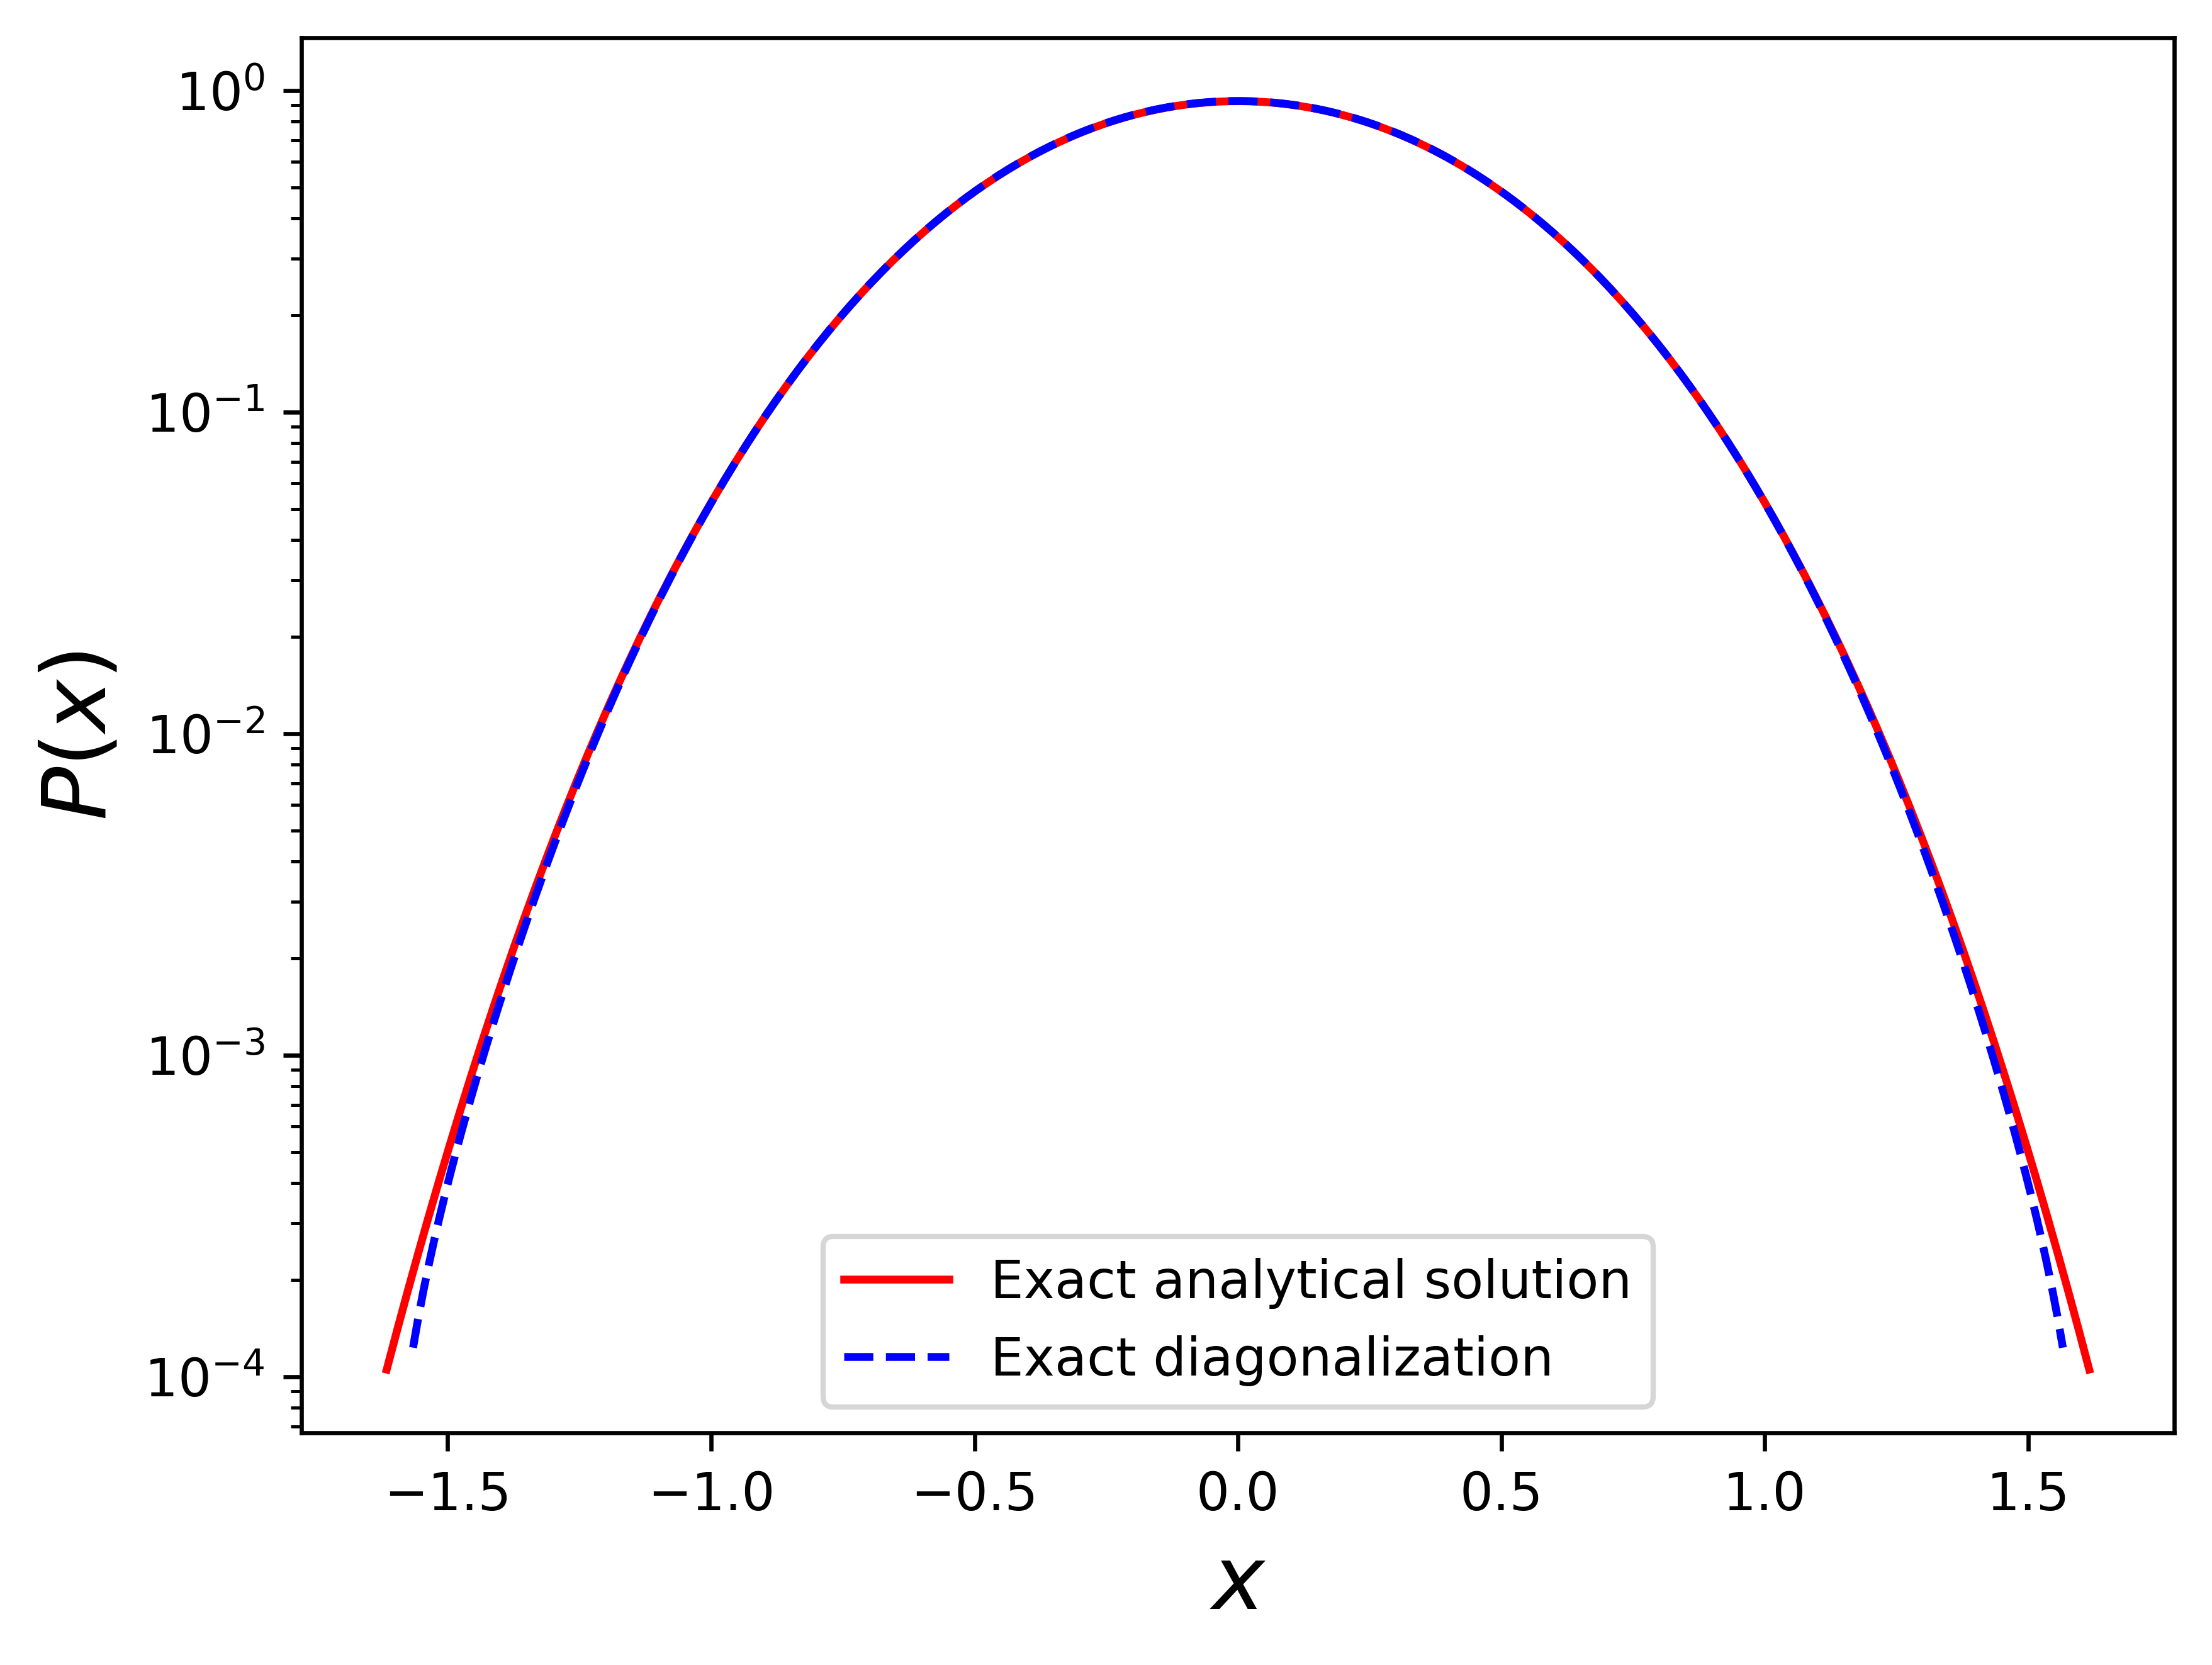

In [8]:
# Compute the RMS deviation and append it to rms_difference for the RMS deviation plot
rms_deviation = rms_diff(y_diagonalization, y)
rms_difference.append(rms_deviation)

# Print the RMS deviation
print('The RMS deviation is:')
print(rms_deviation)
print()

# Compare the steady-state PDFs
y_cutoff = 1e-4

x_classical, y_classical = cutoff_graph(x, y, y_cutoff) # exact analytical solution
x_diagonal, y_diagonal = cutoff_graph(x, y_diagonalization, y_cutoff) # exact diagonalization

fig, ax = plt.subplots(dpi = 600)

# Plot the first set of data on a log base 2 scale
ax.plot(x_classical, y_classical, color = 'r', label = 'Exact analytical solution')

# Plot the second set of data on a log base 2 scale
ax.plot(x_diagonal, y_diagonal, '--b', label = 'Exact diagonalization')

# Set y-axis to a log scale
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('$x$', fontsize = 17)
ax.set_ylabel('$P(x)$', fontsize = 17)

# Show a legend
ax.legend()

### For n = 8

### Compute the steady-state PDF via exact diagonalization

In [9]:
# Define max. size of Hermite polynomial basis size
nmax = 15

## Finding the zeromode through direct integration
cache_projection = integrate_eigenvector(x, y, nmax, L)
x_projection, y_projection = reconstruct_eigenvector(cache_projection)

## Finding the zeromode through diagonalization
op_nonhermitian = create_operator_perturbed(nmax, L, a, c, gamma)
only_even = True

cache_diagonalization = find_zeromode(op_nonhermitian, nmax, x, dx, L, which = "single", only_even = only_even)
x_diagonalization, y_diagonalization = reconstruct_eigenvector(cache_diagonalization, only_even = only_even)

### Compare (exact analytical solution vs. exact diagonalization)

The RMS deviation is:
0.00014210232185859055



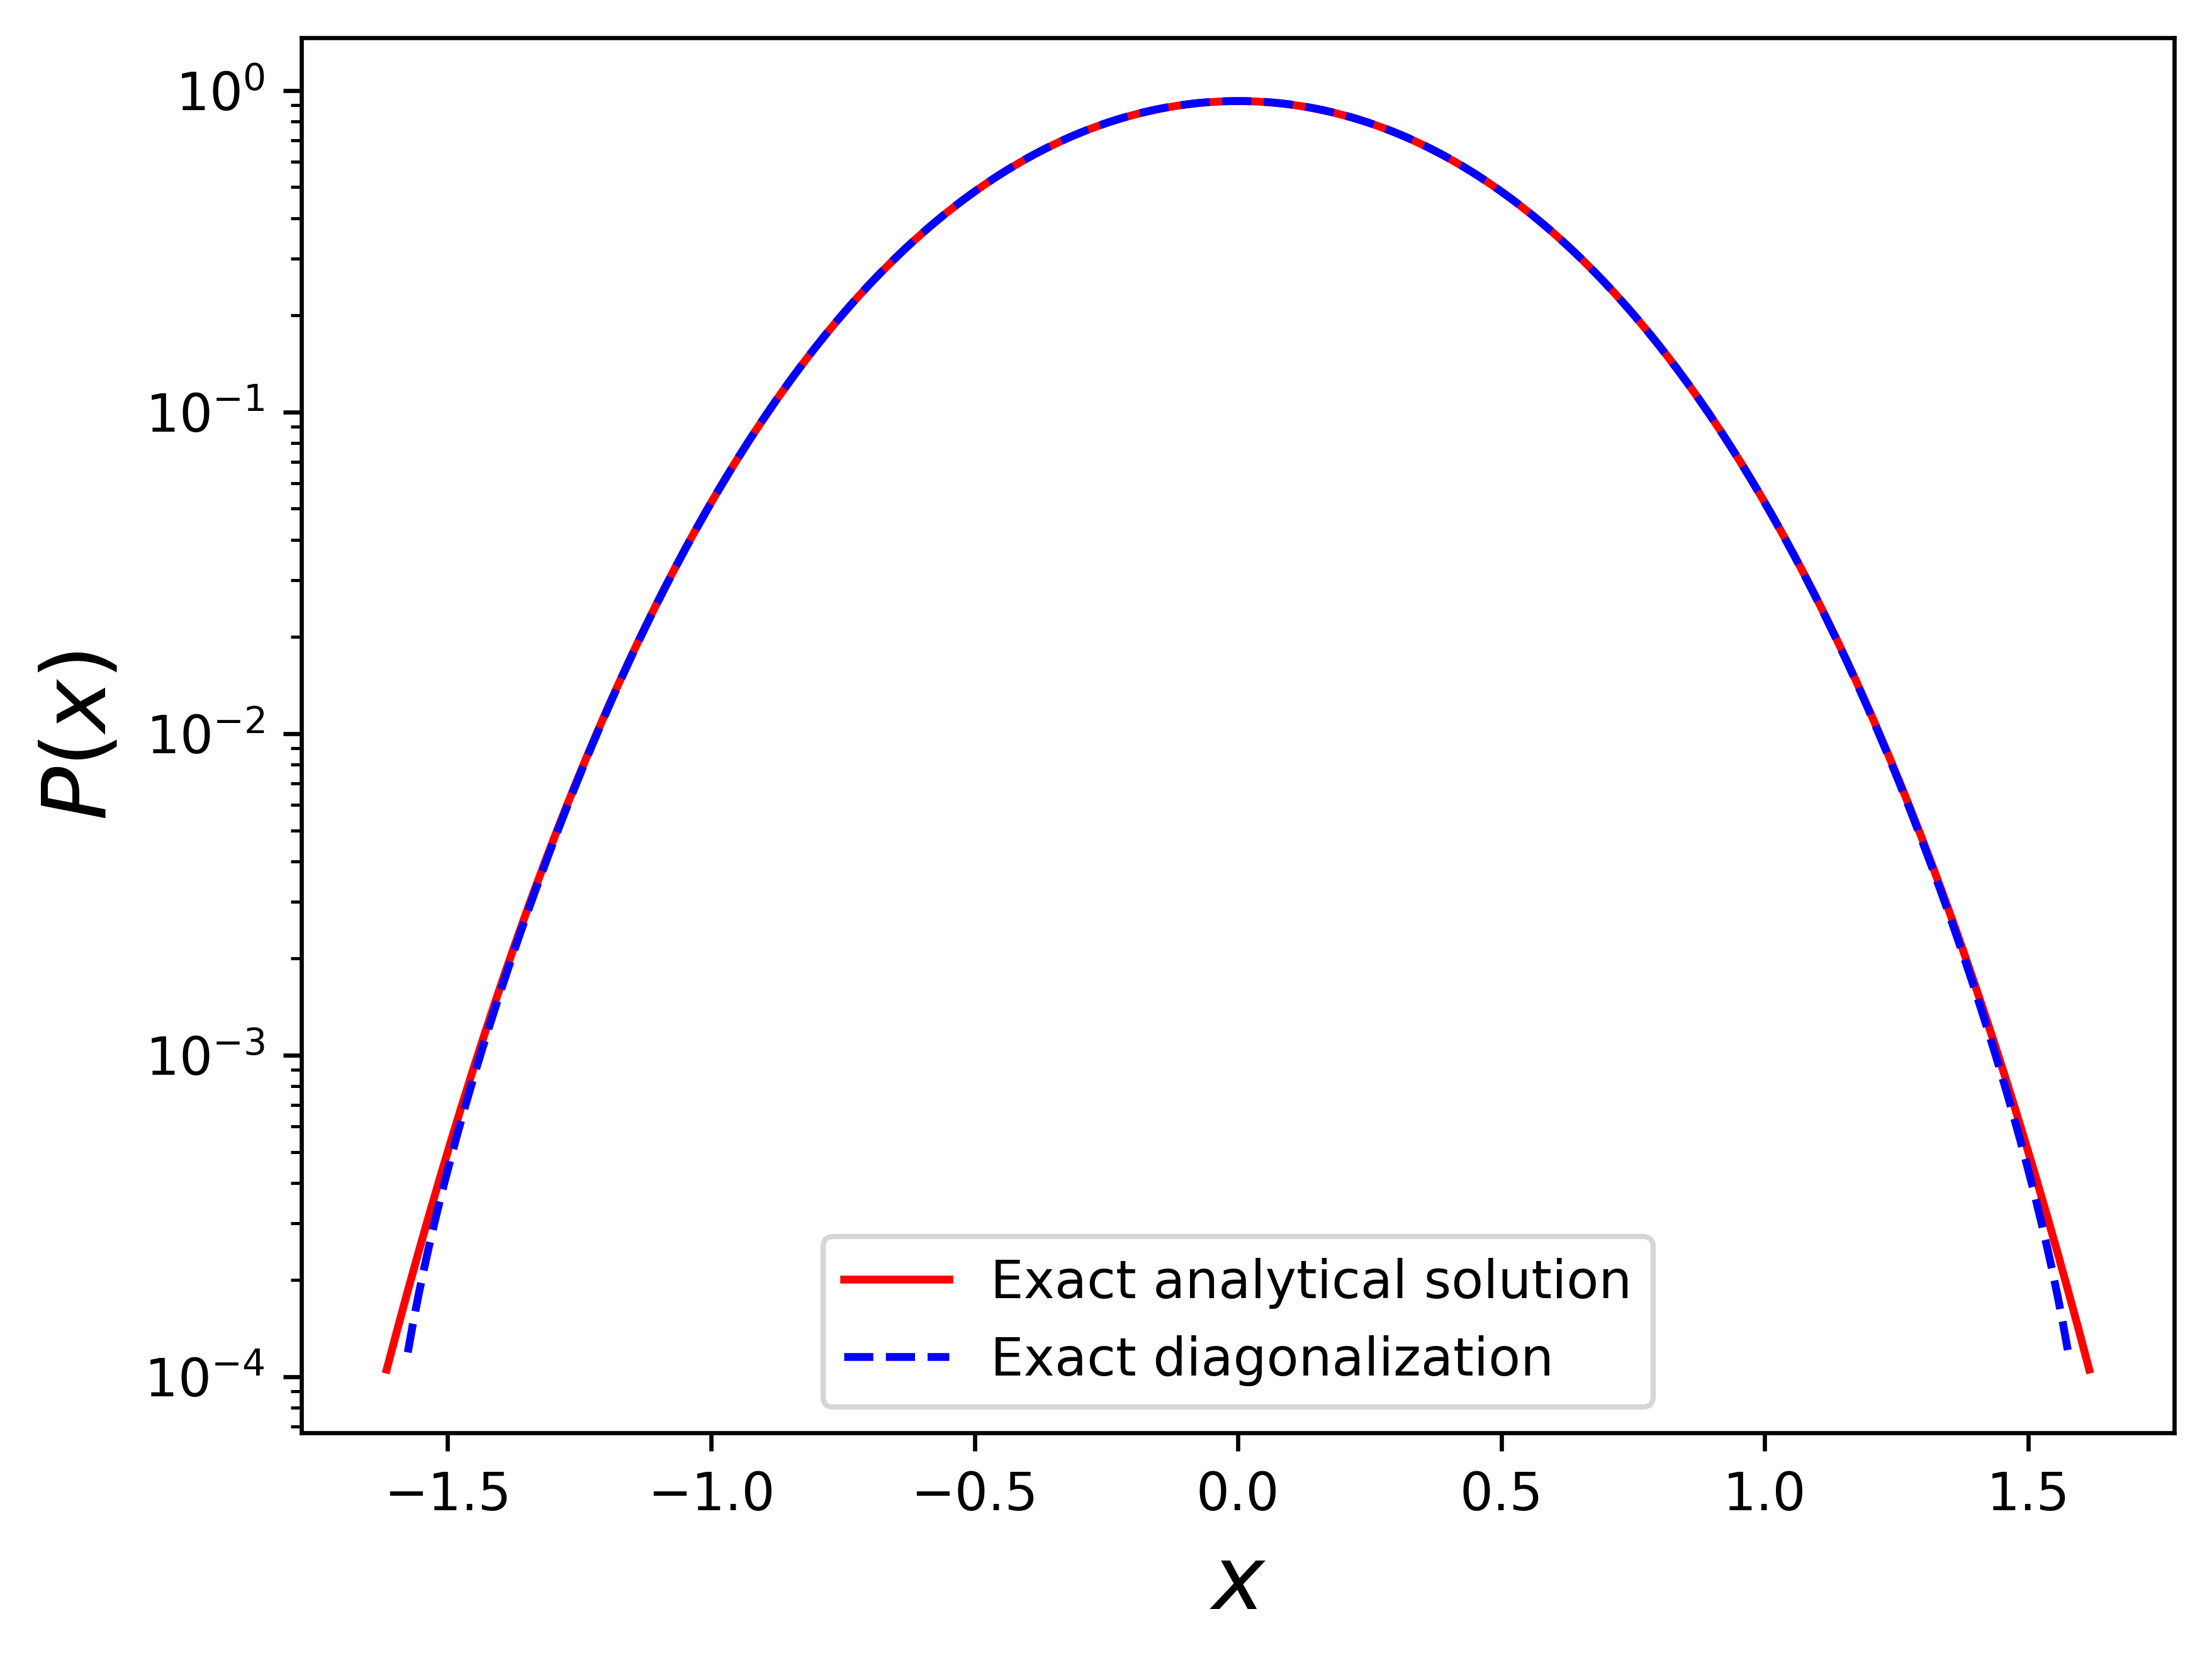

In [10]:
# Compute the RMS deviation and append it to rms_difference for the RMS deviation plot
rms_deviation = rms_diff(y_diagonalization, y)
rms_difference.append(rms_deviation)

# Print the RMS deviation
print('The RMS deviation is:')
print(rms_deviation)
print()

# Compare the steady-state PDFs
y_cutoff = 1e-4

x_classical, y_classical = cutoff_graph(x, y, y_cutoff) # exact analytical solution
x_diagonal, y_diagonal = cutoff_graph(x, y_diagonalization, y_cutoff) # exact diagonalization

fig, ax = plt.subplots(dpi = 600)

# Plot the first set of data on a log base 2 scale
ax.plot(x_classical, y_classical, color = 'r', label = 'Exact analytical solution')

# Plot the second set of data on a log base 2 scale
ax.plot(x_diagonal, y_diagonal, '--b', label = 'Exact diagonalization')

# Set y-axis to a log scale
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('$x$', fontsize = 17)
ax.set_ylabel('$P(x)$', fontsize = 17)

# Show a legend
ax.legend()

### For n = 10

### Compute steady-state PDF via exact diagonalization

In [11]:
# Define max. size of Hermite polynomial basis size
nmax = 19

## Finding the zeromode through direct integration
cache_projection = integrate_eigenvector(x, y, nmax, L)
x_projection, y_projection = reconstruct_eigenvector(cache_projection)

## Finding the zeromode through diagonalization
op_nonhermitian = create_operator_perturbed(nmax, L, a, c, gamma)
only_even = True

cache_diagonalization = find_zeromode(op_nonhermitian, nmax, x, dx, L, which = "single", only_even = only_even)
x_diagonalization, y_diagonalization = reconstruct_eigenvector(cache_diagonalization, only_even = only_even)

### Compare (exact analytical solution vs. exact diagonalization)

The RMS deviation is:
8.503669486543114e-05



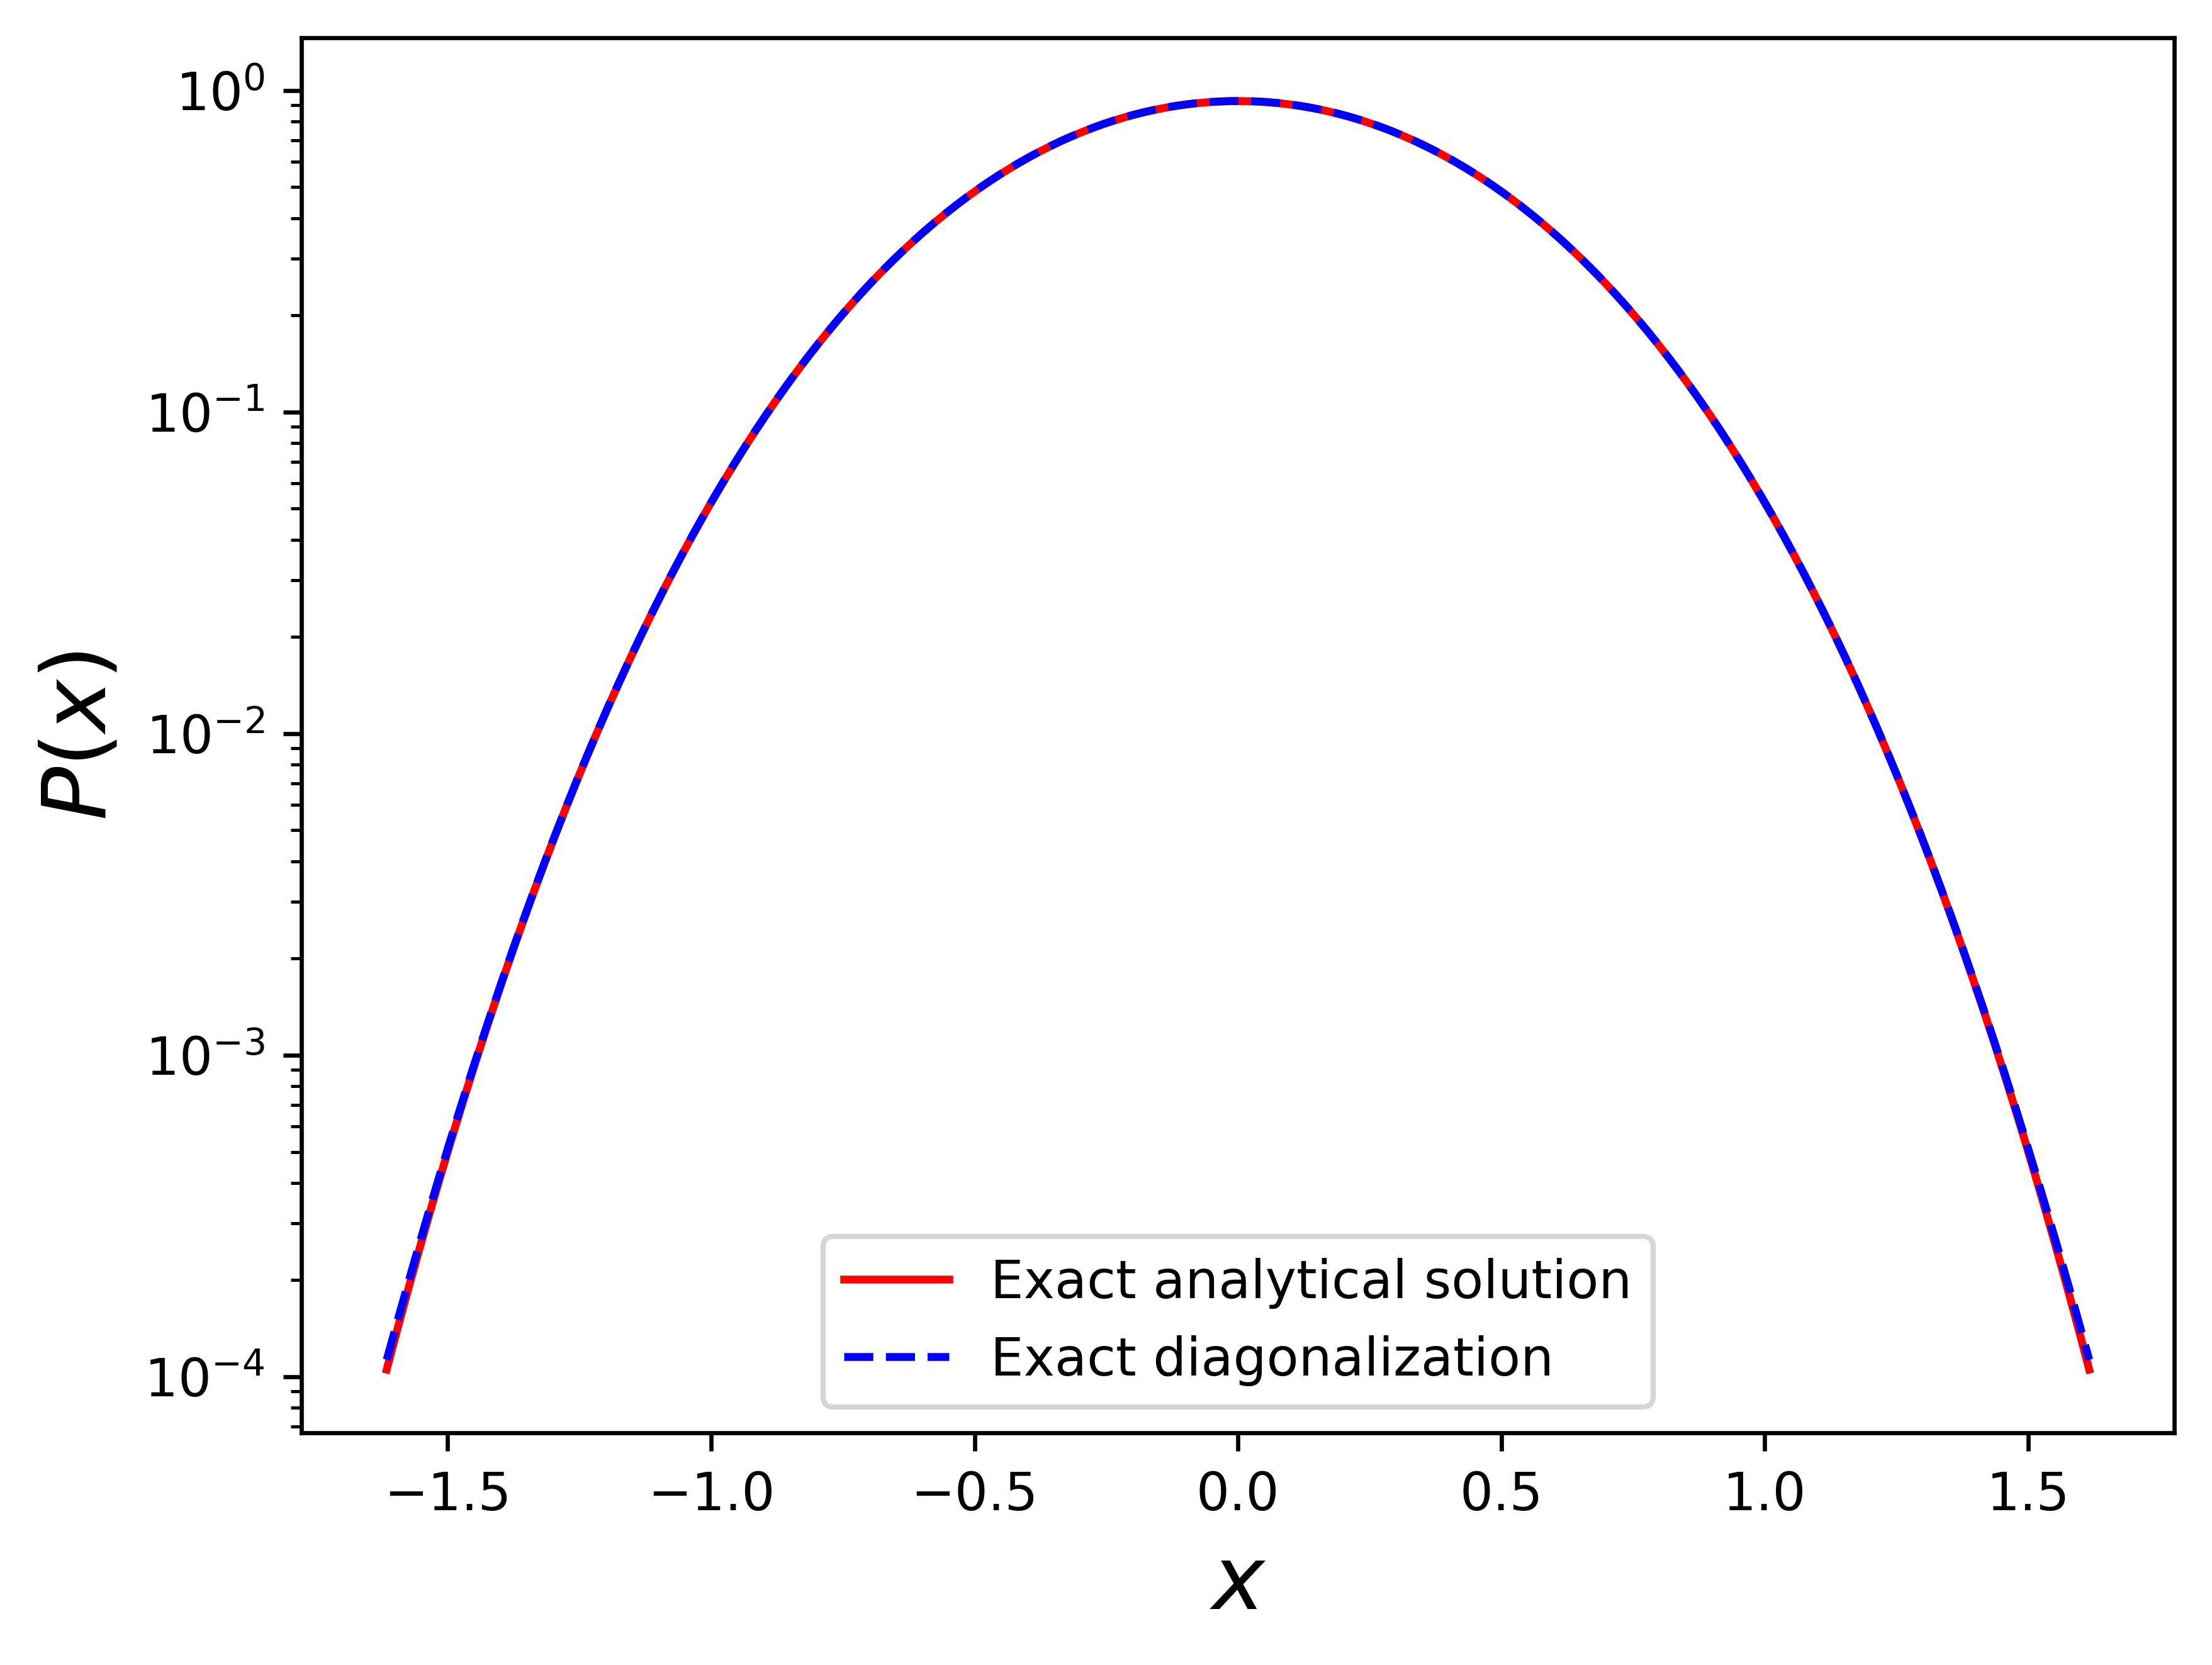

In [12]:
# Compute the RMS deviation and append it to rms_difference for the RMS deviation plot
rms_deviation = rms_diff(y_diagonalization, y)
rms_difference.append(rms_deviation)

# Print the RMS deviation
print('The RMS deviation is:')
print(rms_deviation)
print()

# Compare the steady-state PDFs
y_cutoff = 1e-4

x_classical, y_classical = cutoff_graph(x, y, y_cutoff) # exact analytical solution
x_diagonal, y_diagonal = cutoff_graph(x, y_diagonalization, y_cutoff) # exact diagonalization

fig, ax = plt.subplots(dpi = 600)

# Plot the first set of data on a log base 2 scale
ax.plot(x_classical, y_classical, color = 'r', label = 'Exact analytical solution')

# Plot the second set of data on a log base 2 scale
ax.plot(x_diagonal, y_diagonal, '--b', label = 'Exact diagonalization')

# Set y-axis to a log scale
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('$x$', fontsize = 17)
ax.set_ylabel('$P(x)$', fontsize = 17)

# Show a legend
ax.legend()

### For n = 14

### Compute steady-state PDF via exact diagonalization

In [13]:
# Define max. size of Hermite polynomial basis size
nmax = 27

## Finding the zeromode through direct integration
cache_projection = integrate_eigenvector(x, y, nmax, L)
x_projection, y_projection = reconstruct_eigenvector(cache_projection)

## Finding the zeromode through diagonalization
op_nonhermitian = create_operator_perturbed(nmax, L, a, c, gamma)
only_even = True

cache_diagonalization = find_zeromode(op_nonhermitian, nmax, x, dx, L, which = "single", only_even = only_even)
x_diagonalization, y_diagonalization = reconstruct_eigenvector(cache_diagonalization, only_even = only_even)

### Compare (exact analytical solution vs. exact diagonalization)

The RMS deviation is:
9.163217255127071e-05



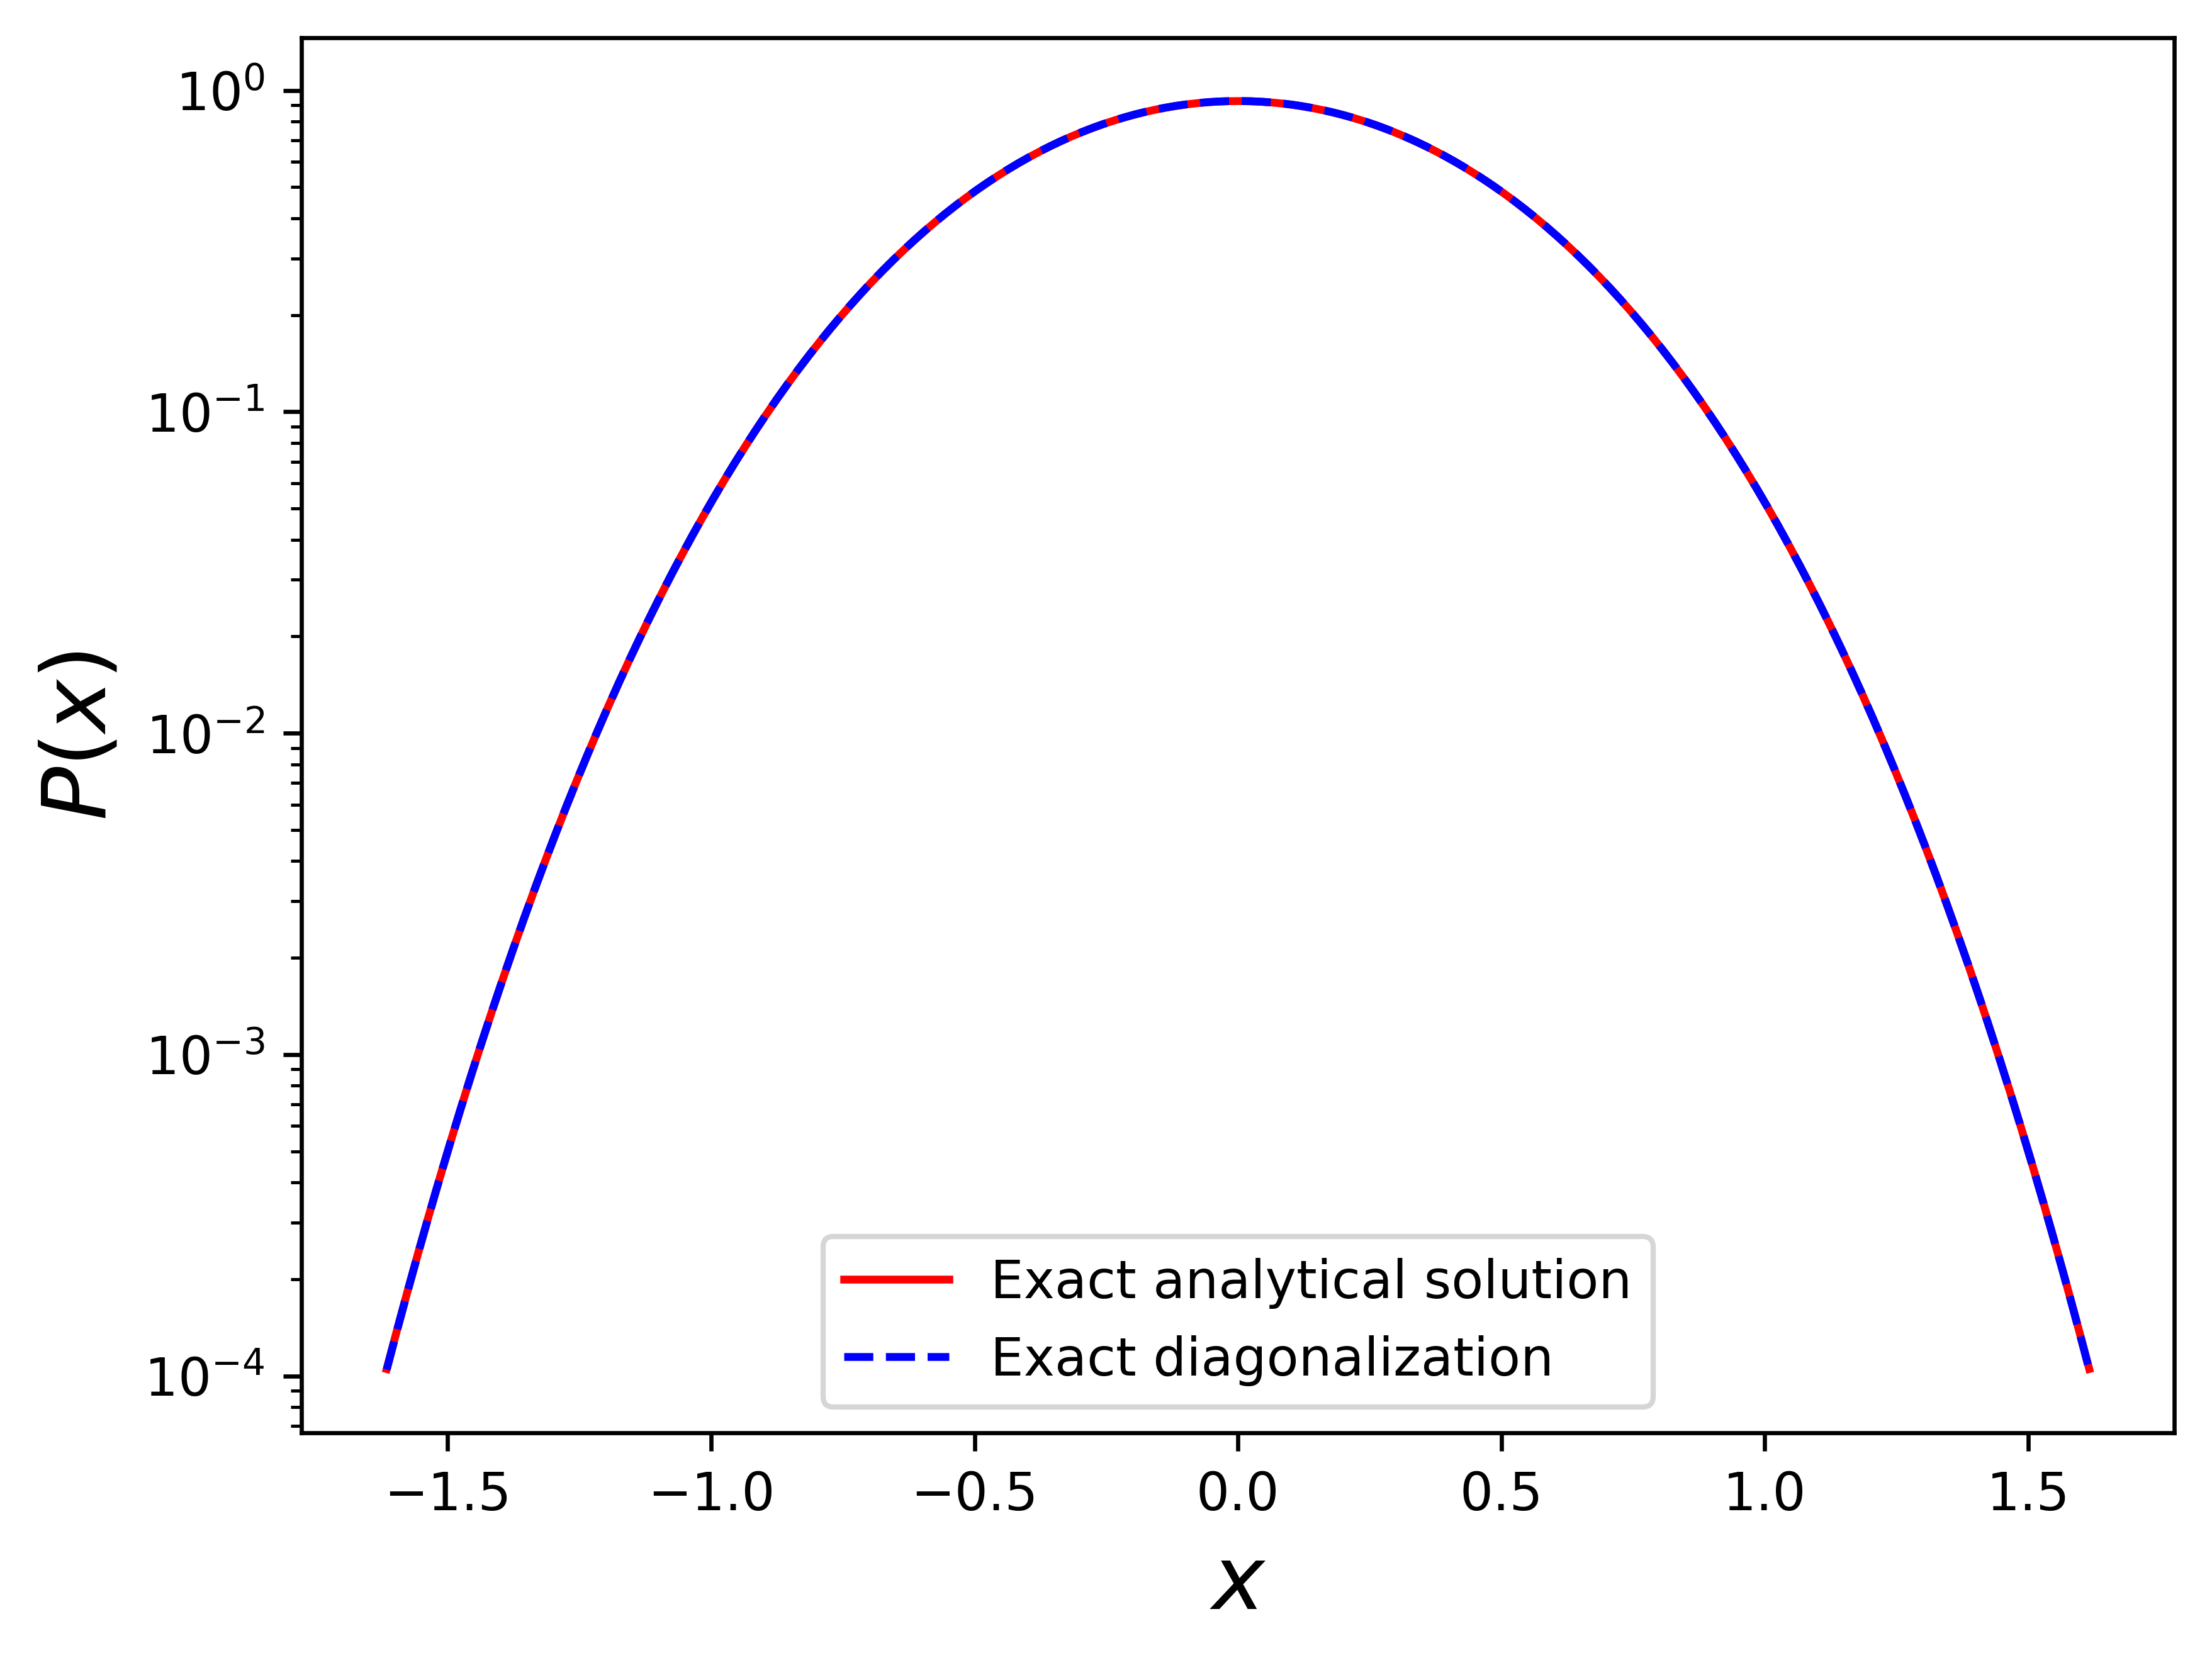

In [14]:
# Compute the RMS deviation and append it to rms_difference for the RMS deviation plot
rms_deviation = rms_diff(y_diagonalization, y)
rms_difference.append(rms_deviation)

# Print the RMS deviation
print('The RMS deviation is:')
print(rms_deviation)
print()

# Compare the steady-state PDFs
y_cutoff = 1e-4

x_classical, y_classical = cutoff_graph(x, y, y_cutoff) # exact analytical solution
x_diagonal, y_diagonal = cutoff_graph(x, y_diagonalization, y_cutoff) # exact diagonalization

fig, ax = plt.subplots(dpi = 600)

# Plot the first set of data on a log base 2 scale
ax.plot(x_classical, y_classical, color = 'r', label = 'Exact analytical solution')

# Plot the second set of data on a log base 2 scale
ax.plot(x_diagonal, y_diagonal, '--b', label = 'Exact diagonalization')

# Set y-axis to a log scale
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('$x$', fontsize = 17)
ax.set_ylabel('$P(x)$', fontsize = 17)

# Show a legend
ax.legend()

### For n = 18

### Compute steady-state PDF via exact diagonalization

In [15]:
# Define max. size of Hermite polynomial basis size
nmax = 35

## Finding the zeromode through direct integration
cache_projection = integrate_eigenvector(x, y, nmax, L)
x_projection, y_projection = reconstruct_eigenvector(cache_projection)

## Finding the zeromode through diagonalization
op_nonhermitian = create_operator_perturbed(nmax, L, a, c, gamma)
only_even = True

cache_diagonalization = find_zeromode(op_nonhermitian, nmax, x, dx, L, which = "single", only_even = only_even)
x_diagonalization, y_diagonalization = reconstruct_eigenvector(cache_diagonalization, only_even = only_even)

### Compare (exact analytical solution vs. exact diagonalization)

The RMS deviation is:
9.126520619800052e-05



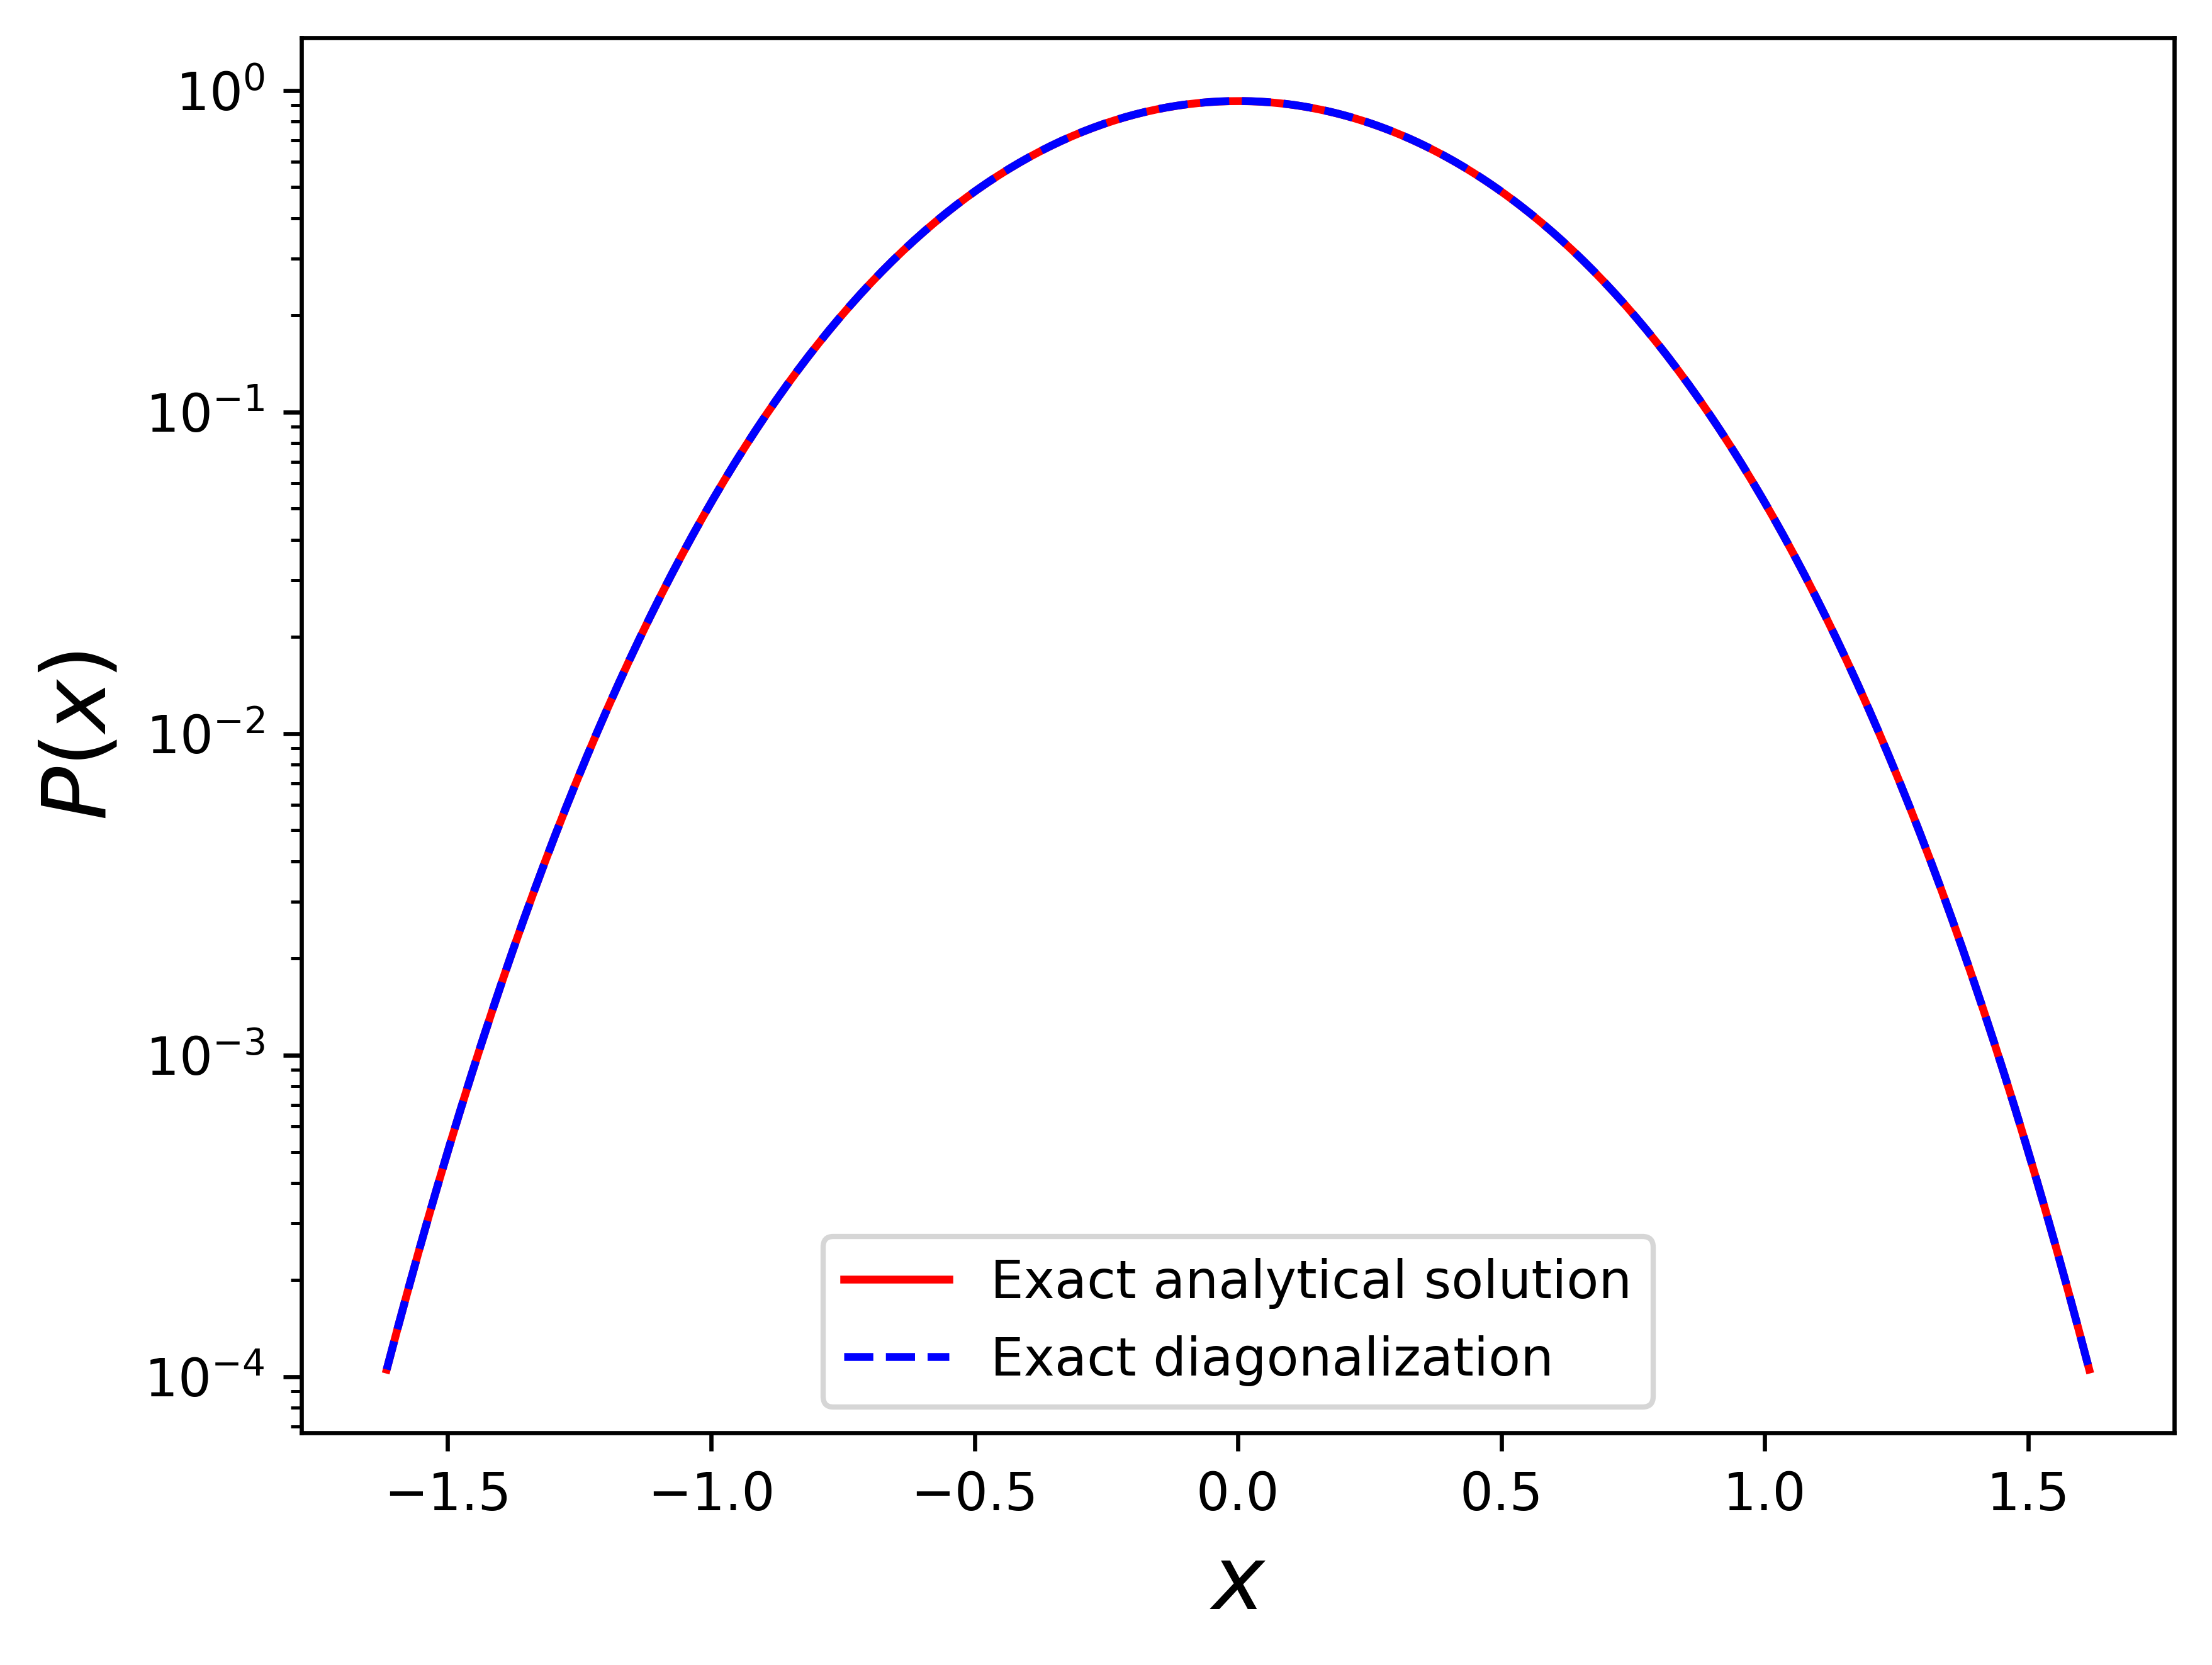

In [16]:
# Compute the RMS deviation and append it to rms_difference for the RMS deviation plot
rms_deviation = rms_diff(y_diagonalization, y)
rms_difference.append(rms_deviation)

# Print the RMS deviation
print('The RMS deviation is:')
print(rms_deviation)
print()

# Compare the steady-state PDFs
y_cutoff = 1e-4

x_classical, y_classical = cutoff_graph(x, y, y_cutoff) # exact analytical solution
x_diagonal, y_diagonal = cutoff_graph(x, y_diagonalization, y_cutoff) # exact diagonalization

fig, ax = plt.subplots(dpi = 600)

# Plot the first set of data on a log base 2 scale
ax.plot(x_classical, y_classical, color = 'r', label = 'Exact analytical solution')

# Plot the second set of data on a log base 2 scale
ax.plot(x_diagonal, y_diagonal, '--b', label = 'Exact diagonalization')

# Set y-axis to a log scale
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('$x$', fontsize = 17)
ax.set_ylabel('$P(x)$', fontsize = 17)

# Show a legend
ax.legend()

## For n = 24

### Compute steady-state PDF via exact diagonalization

In [18]:
# Define max. size of Hermite polynomial basis size
nmax = 47

## Finding the zeromode through direct integration
cache_projection = integrate_eigenvector(x, y, nmax, L)
x_projection, y_projection = reconstruct_eigenvector(cache_projection)

## Finding the zeromode through diagonalization
op_nonhermitian = create_operator_perturbed(nmax, L, a, c, gamma)
only_even = True

cache_diagonalization = find_zeromode(op_nonhermitian, nmax, x, dx, L, which = "single", only_even = only_even)
x_diagonalization, y_diagonalization = reconstruct_eigenvector(cache_diagonalization, only_even = only_even)

### Compare (exact analytical solution vs. exact diagonalization)

The RMS deviation is:
9.127763175385255e-05



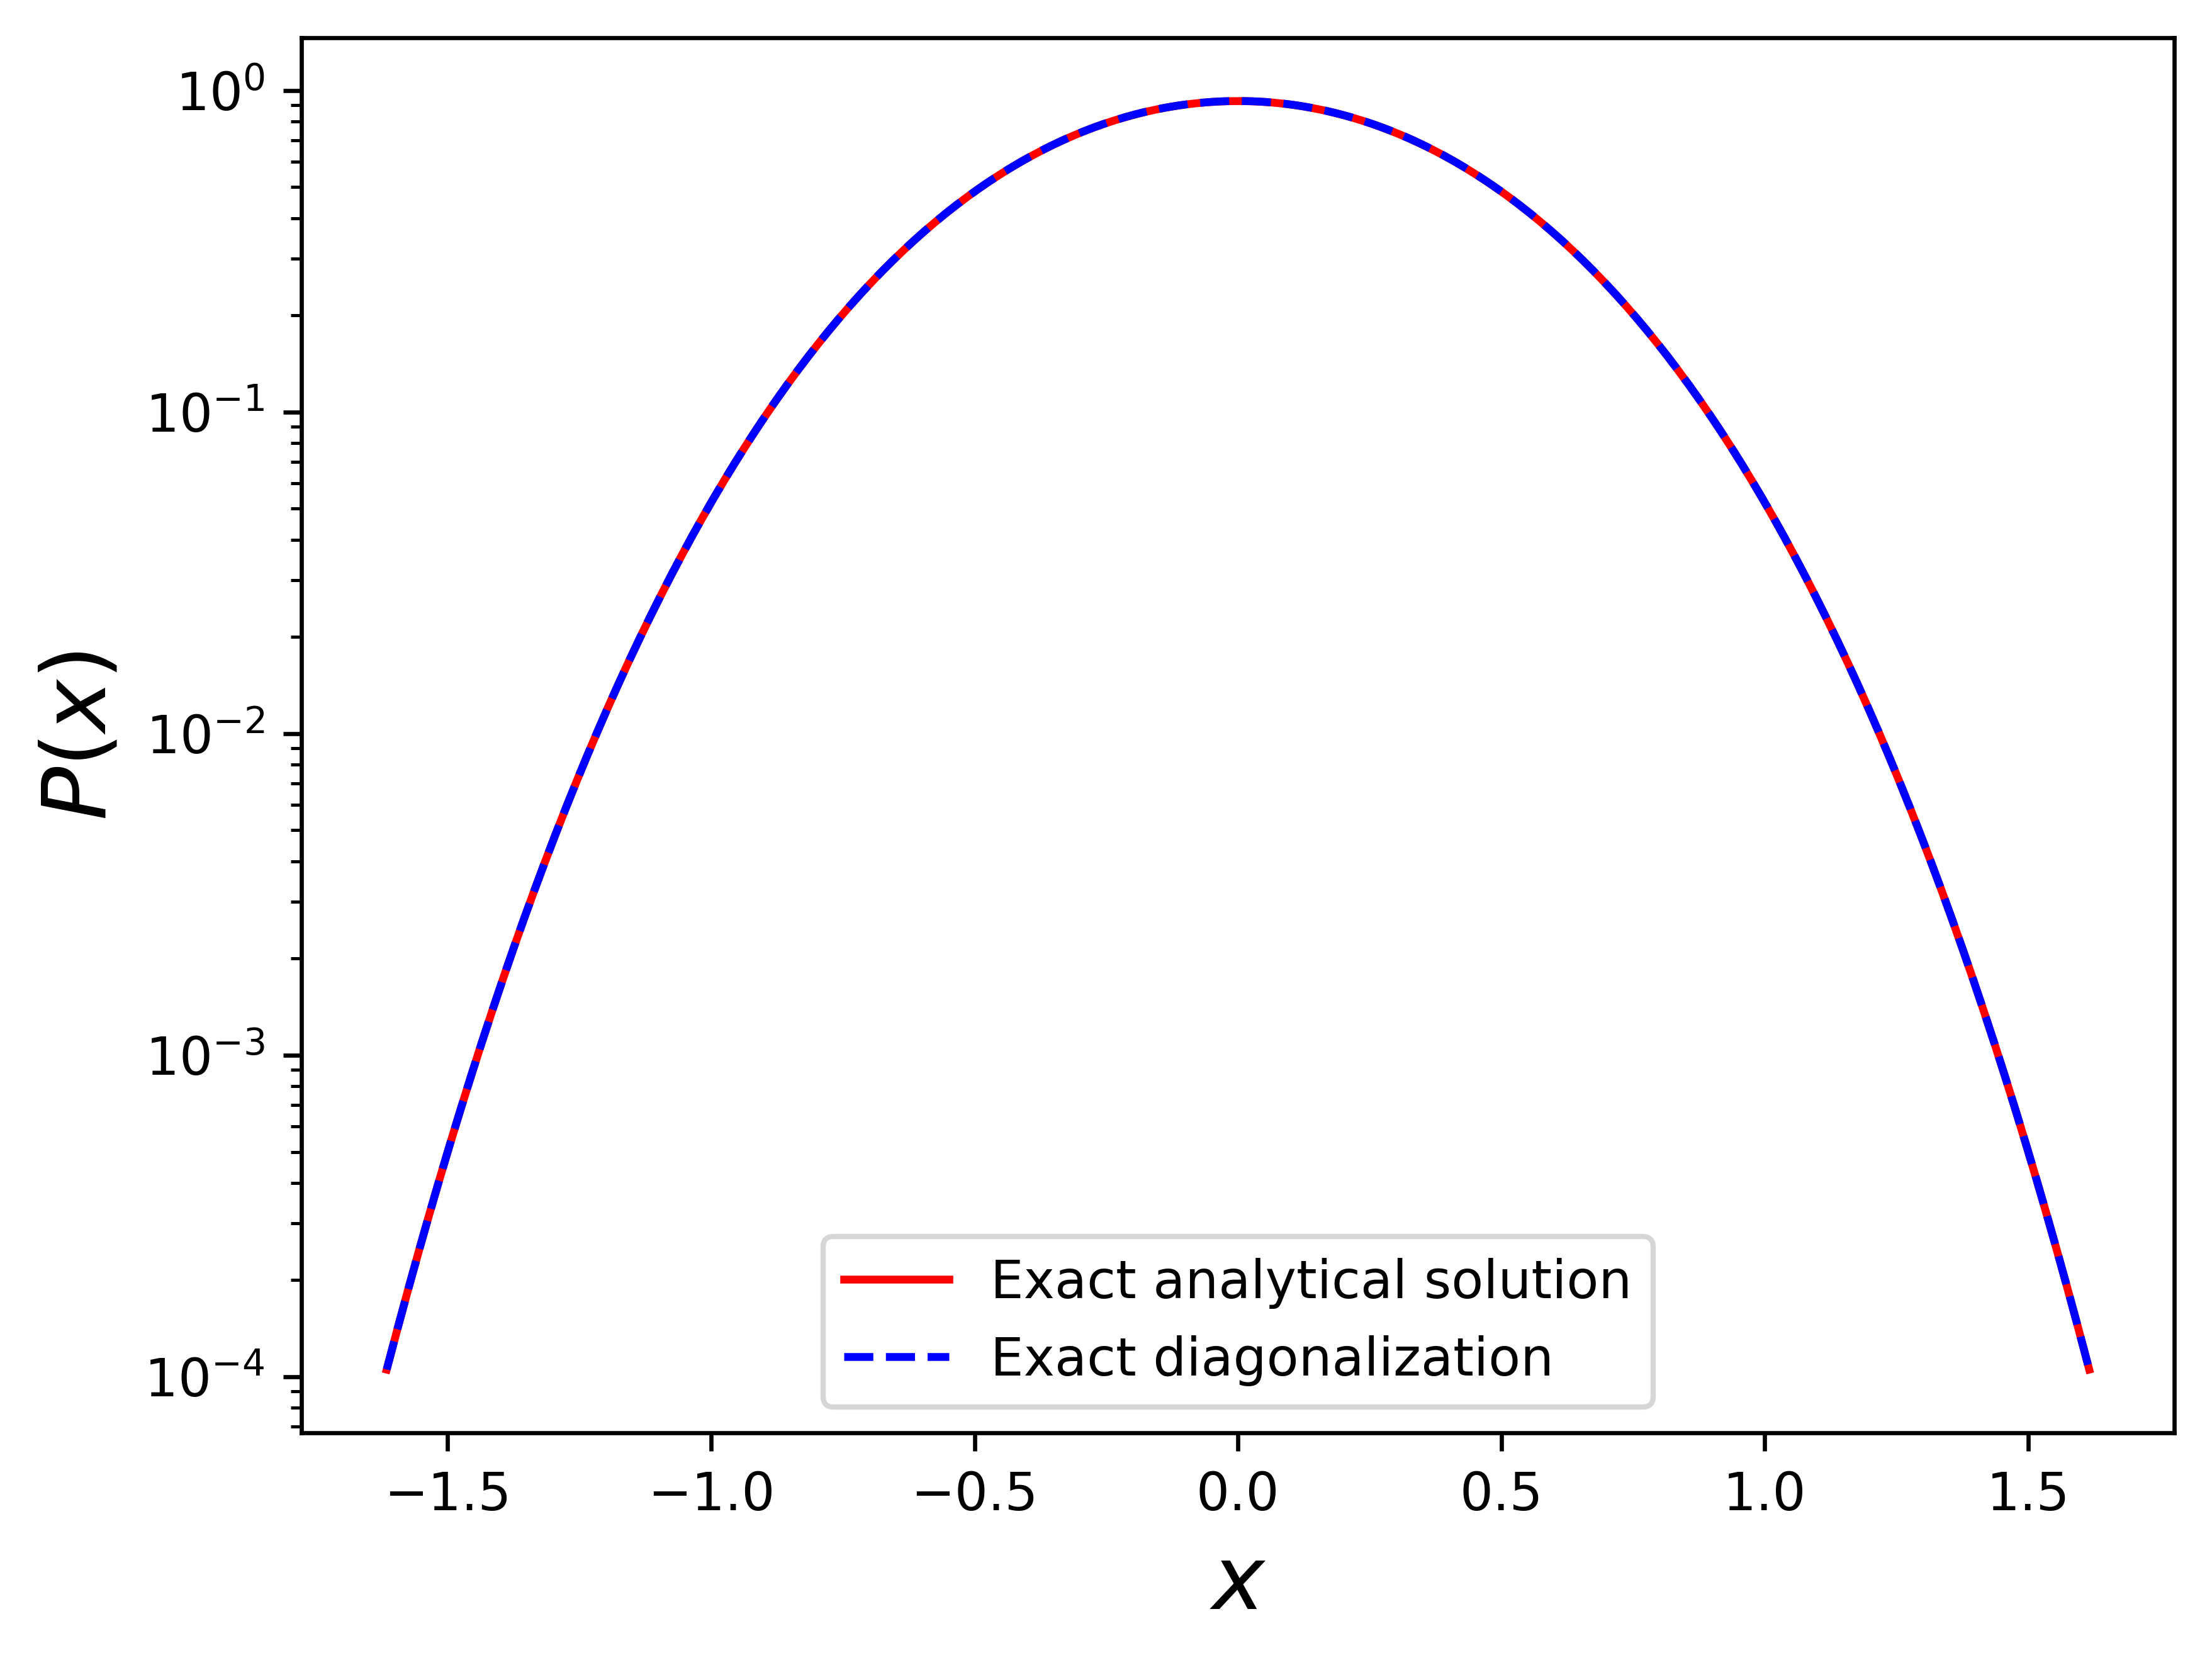

In [19]:
# Compute the RMS deviation and append it to rms_difference for the RMS deviation plot
rms_deviation = rms_diff(y_diagonalization, y)
rms_difference.append(rms_deviation)

# Print the RMS deviation
print('The RMS deviation is:')
print(rms_deviation)
print()

# Compare the steady-state PDFs
y_cutoff = 1e-4

x_classical, y_classical = cutoff_graph(x, y, y_cutoff) # exact analytical solution
x_diagonal, y_diagonal = cutoff_graph(x, y_diagonalization, y_cutoff) # exact diagonalization

fig, ax = plt.subplots(dpi = 600)

# Plot the first set of data on a log base 2 scale
ax.plot(x_classical, y_classical, color = 'r', label = 'Exact analytical solution')

# Plot the second set of data on a log base 2 scale
ax.plot(x_diagonal, y_diagonal, '--b', label = 'Exact diagonalization')

# Set y-axis to a log scale
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('$x$', fontsize = 17)
ax.set_ylabel('$P(x)$', fontsize = 17)

# Show a legend
ax.legend()

## Plot the RMS deviation vs. basis size

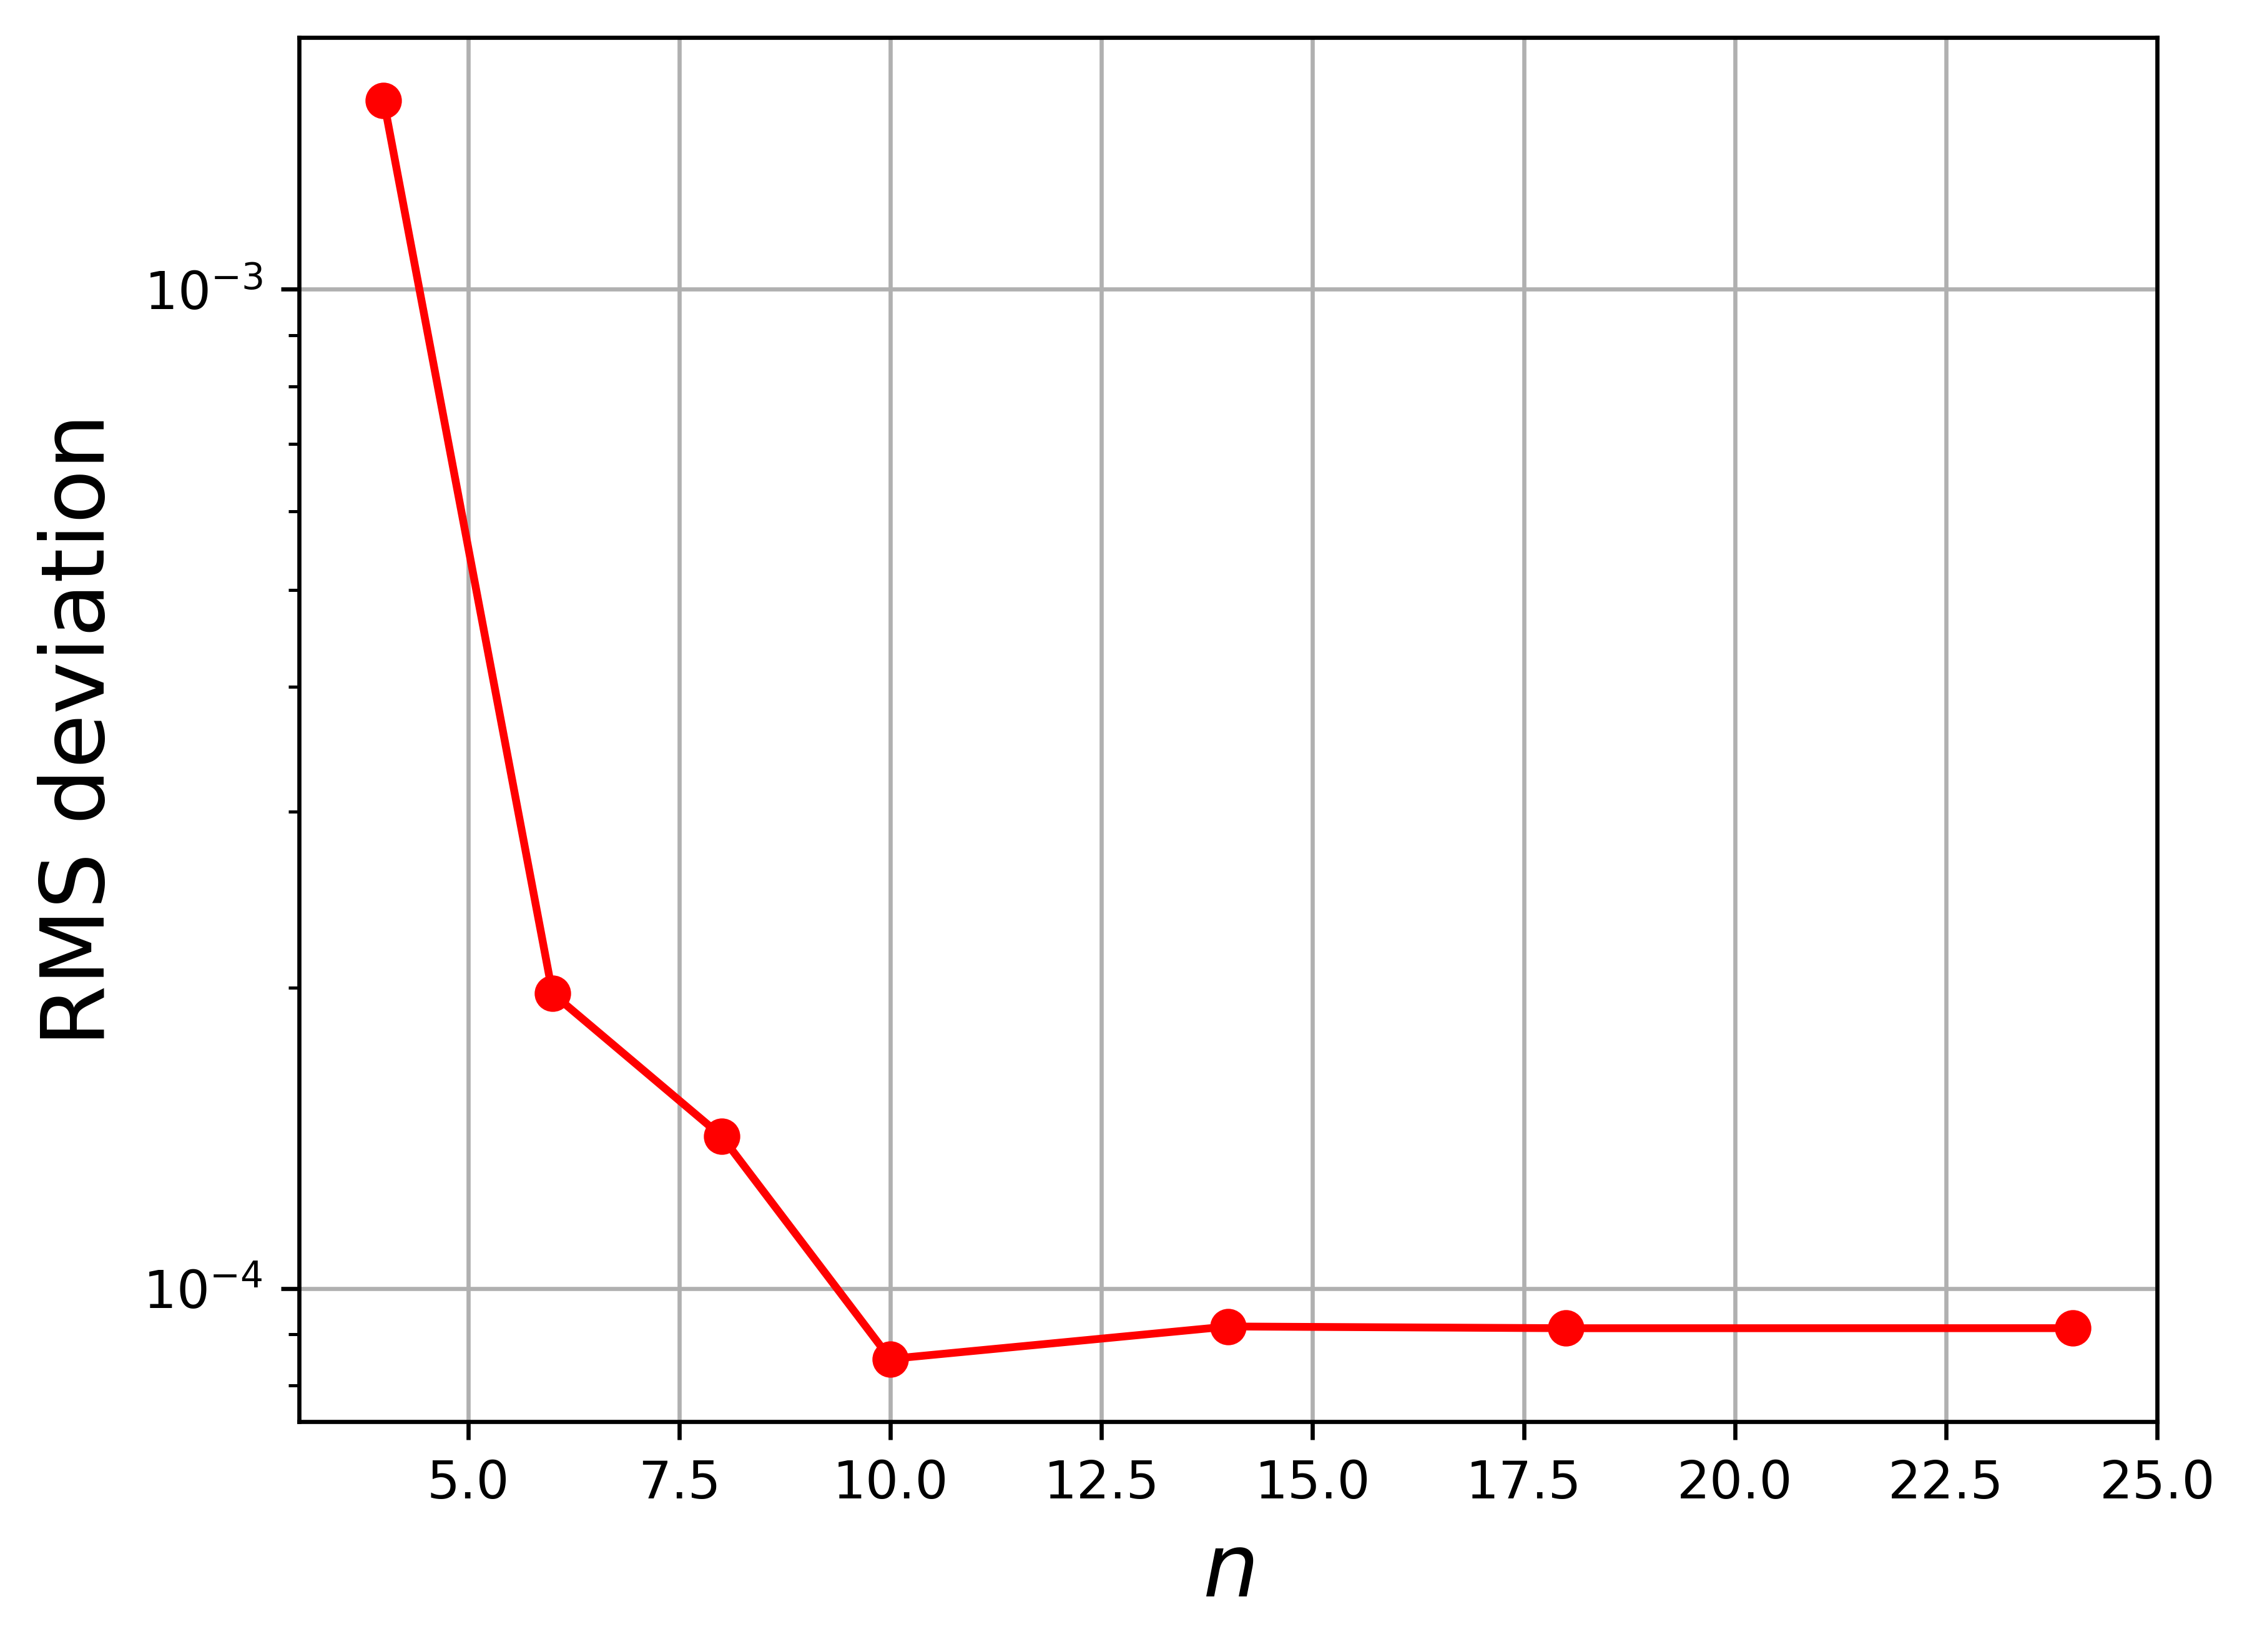

In [20]:
# Initialize basis size array
n = [4, 6, 8, 10, 14, 18, 24]

# Plot
plt.figure(dpi = 600)
plt.xlabel('$n$', fontsize = 17)
plt.ylabel('RMS deviation', fontsize = 17)

plt.plot(n, rms_difference, 'r', marker = 'o')
plt.yscale('log')

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()